# 概要
- DBにアクセスしてデータを抜き取る
- データをナイーブに合うようにクレンジング
- ナイーブベイズにかける
- 精度をみる

# ライブラリimport 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import japanize_matplotlib 
import scipy  
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import seaborn as sns
import missingno as msno
from tqdm import tqdm_notebook as tqdm
import datetime
import plotly
plotly.offline.init_notebook_mode(connected=False)
import warnings
warnings.filterwarnings('ignore') # warningが出ないように設定
pd.set_option("display.max_rows", None) # pandasの表示上限をなくす
pd.set_option("display.max_columns", None) # pandasの表示上限をなくす

In [2]:
from sklearn.naive_bayes import GaussianNB # ガウシアン
import sqlite3
from sklearn.feature_extraction.text import CountVectorizer as CV
import MeCab

# DBに接続

In [3]:
#(id real, category real, airticle text, url text)
path = "../sqlite3/GunosyText.db"
conn = sqlite3.connect(path)

In [4]:
c = conn.cursor()

In [5]:
sql_command = 'select * from textlist'
c = c.execute(sql_command)

In [6]:
#textをリストに入れる
corpus = []
for row in c:
    corpus.append(row[2])

In [7]:
sql_command = 'select * from textlist'
c = c.execute(sql_command)

# URLをリストに入れる
url_list = []
for row in c:
    url_list.append(row[3])

In [8]:
url_list

['https://gunosy.com/articles/RQOxQ',
 'https://gunosy.com/articles/RQOxQ',
 'https://gunosy.com/articles/RQOxQ',
 'https://gunosy.com/articles/Rrwjh',
 'https://gunosy.com/articles/Rrwjh',
 'https://gunosy.com/articles/Roec0',
 'https://gunosy.com/articles/Roec0',
 'https://gunosy.com/articles/aXojR',
 'https://gunosy.com/articles/aXojR',
 'https://gunosy.com/articles/atcnB',
 'https://gunosy.com/articles/atcnB',
 'https://gunosy.com/articles/RVfpQ',
 'https://gunosy.com/articles/RVfpQ',
 'https://gunosy.com/articles/RNHgA',
 'https://gunosy.com/articles/RNHgA',
 'https://gunosy.com/articles/awX5y',
 'https://gunosy.com/articles/awX5y',
 'https://gunosy.com/articles/aLQ67',
 'https://gunosy.com/articles/aLQ67',
 'https://gunosy.com/articles/aGEwy',
 'https://gunosy.com/articles/aGEwy',
 'https://gunosy.com/articles/Ro0LM',
 'https://gunosy.com/articles/Ro0LM',
 'https://gunosy.com/articles/atAg7',
 'https://gunosy.com/articles/apcVQ',
 'https://gunosy.com/articles/apcVQ',
 'https://gu

# データのクレンジング
- CountVec
- 文字ごとにカウント後に単語ごとに分析を行う
- [{word:num, word:num.....},{word:num,.....}.....]

## 文章ごとに単語ごとにカウント=>リスト

In [9]:
id_word_count_dic_list = []

for row in tqdm(corpus):
    
    #文章から名詞をとる
    keywords = []
    t = MeCab.Tagger('')
    t.parse('')
    m = t.parseToNode(row)
 
    while m:
        if m.feature.split(',')[0] == '名詞':
            keywords.append(m.surface)
        m = m.next

    #wordを数える=>dic
    word_count_dic = {}
    for word in keywords:
        if word not in word_count_dic:
            word_count_dic[word] = 1
        else:
            word_count_dic[word] += 1
    id_word_count_dic_list.append(word_count_dic)

## 記事ごとに、その文書の名詞と出現数が正しく辞書化できているか確認

In [10]:
len(id_word_count_dic_list) == len(corpus)

True

In [11]:
id_word_count_dic_list[0]

{'グノシー': 1,
 '吉岡': 3,
 '里': 1,
 '帆': 1,
 '仕草': 1,
 'ファン': 2,
 '悶絶': 1,
 'どん': 3,
 'ぎつね': 2,
 '写真': 5,
 '集': 4,
 'メイキング': 2,
 '2': 5,
 '弾': 3,
 '公開': 6,
 'None': 2,
 '1': 2,
 '年越し': 1,
 'そば': 1,
 '様子': 3,
 '神社': 1,
 '参拝': 1,
 '撮影': 2,
 '風景': 1,
 '映像': 2,
 '今回': 1,
 '場所': 1,
 '移動': 1,
 '際': 1,
 'オフショットムービー': 1,
 '動画': 2,
 '前': 1,
 'ぎつねさ': 1,
 'ー': 1,
 'スタッフ': 2,
 '声': 2,
 'ところ': 1,
 'かけ': 1,
 '笑顔': 1,
 '姿': 4,
 '尻': 1,
 'フリ': 4,
 'フサフサ': 1,
 '尻尾': 1,
 'アピール': 1,
 'さ': 3,
 'ギュギュッ': 1,
 '凝縮': 1,
 '全て': 1,
 '何': 1,
 '回': 1,
 'おしり': 1,
 'キュン': 1,
 '死': 1,
 '～」「': 1,
 '多く': 1,
 '絶賛': 1,
 'コメント': 1,
 '記事': 1,
 'オジ': 1,
 '様': 1,
 '心': 1,
 'わし': 1,
 '掴み': 1,
 '妖艶': 1,
 '大人': 1,
 '魅力': 1,
 'グラビア': 1,
 '一挙': 1,
 'コス': 1,
 'プレ': 1,
 '東京': 1,
 'コミコン': 1,
 '2018': 1,
 '女性': 1,
 'ヒーロー': 1,
 'アメコミ': 1,
 '愛': 1,
 'レイヤー': 1,
 '集合': 1,
 '永野': 1,
 '芽': 1,
 '郁': 1,
 '10': 1,
 '代': 1,
 'ラスト': 1,
 'st': 1,
 '発売': 1,
 '決定': 1,
 '最近': 1,
 '人気': 1,
 'ニュース': 2,
 '生田': 2,
 '絵梨': 2,
 '花': 2,
 'ランジェリー': 2,
 '解禁': 1,

# dfにまとめる

## 全記事の全単語の抜き出し

In [12]:
word_list = []
for word_dic in tqdm(id_word_count_dic_list):
    for word in word_dic.keys():
        if word not in word_list:
            word_list.append(word)
word_list

['グノシー',
 '吉岡',
 '里',
 '帆',
 '仕草',
 'ファン',
 '悶絶',
 'どん',
 'ぎつね',
 '写真',
 '集',
 'メイキング',
 '2',
 '弾',
 '公開',
 'None',
 '1',
 '年越し',
 'そば',
 '様子',
 '神社',
 '参拝',
 '撮影',
 '風景',
 '映像',
 '今回',
 '場所',
 '移動',
 '際',
 'オフショットムービー',
 '動画',
 '前',
 'ぎつねさ',
 'ー',
 'スタッフ',
 '声',
 'ところ',
 'かけ',
 '笑顔',
 '姿',
 '尻',
 'フリ',
 'フサフサ',
 '尻尾',
 'アピール',
 'さ',
 'ギュギュッ',
 '凝縮',
 '全て',
 '何',
 '回',
 'おしり',
 'キュン',
 '死',
 '～」「',
 '多く',
 '絶賛',
 'コメント',
 '記事',
 'オジ',
 '様',
 '心',
 'わし',
 '掴み',
 '妖艶',
 '大人',
 '魅力',
 'グラビア',
 '一挙',
 'コス',
 'プレ',
 '東京',
 'コミコン',
 '2018',
 '女性',
 'ヒーロー',
 'アメコミ',
 '愛',
 'レイヤー',
 '集合',
 '永野',
 '芽',
 '郁',
 '10',
 '代',
 'ラスト',
 'st',
 '発売',
 '決定',
 '最近',
 '人気',
 'ニュース',
 '生田',
 '絵梨',
 '花',
 'ランジェリー',
 '解禁',
 'FRIDAY',
 '先行',
 '夫婦',
 '有名人',
 'ランキング',
 '小嶋',
 '陽',
 '菜',
 '一般人',
 'あぜん',
 '...',
 '芸能',
 '界',
 '固執',
 '藤田',
 'ニコル',
 'セクシー',
 'カット',
 'ドキドキ',
 '僕',
 '韓国',
 '人',
 'ん',
 '日本人',
 '意外',
 '芸能人',
 'たち',
 '矢部',
 '浩之',
 '念願',
 'ゴチ',
 '復帰',
 '...「',
 '子供',
 '訴え',
 '億',
 '円',
 '整形',
 'サイボーグ',
 

In [13]:
len(word_list)

11269

## 不必要な単語のリスト化

In [14]:
import re

pattern = r'(\w)+'
repatter = re.compile(pattern)
drop_col = []
col =[]
for word in tqdm(word_list):
    result = repatter.match(word)
    if result:
        col.append(word)
    else:
        drop_col.append(word)

In [15]:
drop_col

['～」「',
 '...',
 '...「',
 '!?',
 '(',
 ')',
 '...」\u3000',
 '-',
 '～',
 '！～',
 ')」',
 '/',
 '・',
 '－',
 '％',
 '!?\u3000“',
 '-」',
 ',',
 '......',
 '!!\u3000',
 '&',
 '...\u3000',
 '%',
 '!!」',
 '-」「',
 '\u3000(',
 '\u3000「#',
 '?」',
 '.',
 ':',
 '......\u3000「',
 '......『',
 '(？)',
 '......\u3000',
 '!',
 '=「',
 '"',
 '【@',
 '~',
 '⇒',
 '℃-',
 '......「',
 '!)',
 '[',
 ']＝',
 ')\u3000■',
 '!!\u3000●',
 '”!',
 '?',
 '\u3000[',
 ']\u3000[',
 ']\u3000',
 ')\u3000',
 '!?\u3000「',
 '=',
 '”...？',
 ')。\u3000',
 '...。」\u3000',
 '】★★★★★\u3000',
 '】★★★★★\u3000【',
 '!?『',
 ')\u3000＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊\u3000■',
 '...！',
 '~！。',
 '*´',
 '｀)！\u3000',
 '？\u3000(',
 '://',
 '(^_^;)',
 ')!!\u3000',
 '♡\u3000',
 '♪\u3000',
 '~」',
 '♪】',
 '♡',
 '......」「',
 '！\u3000＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊\u3000■',
 '...」(',
 '(*',
 '∀`*)\u3000',
 '...？',
 '！(',
 '♡\u3000〝',
 '〟',
 '♡】',
 '(*´',
 '｀*)',
 '♡\u3000【',
 '♪（',
 '!?「',
 ')』\u3000',
 '❤',
 '@',
 '\u3000＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊\u3000■',
 '｀*)\u3000',
 '(´∀｀)',
 '♪'

In [16]:
len(drop_col)

211

## 各記事のカテゴリをDBから抜き出し

In [17]:
category_order = []
sql_command = 'select * from textlist'
c = c.execute(sql_command)

for row in c:
    category_order.append(row[1])

## df

In [18]:
for_df_list = []
for word_count_dic in id_word_count_dic_list:
    num_list = []
    for order_word in word_list:
        if order_word not in word_count_dic.keys():
            num_list.append(0)
        else:
            num_list.append(word_count_dic[order_word])
    for_df_list.append(num_list)

In [19]:
len(for_df_list)

468

In [20]:
df = pd.DataFrame(for_df_list, columns=word_list)

In [21]:
# カテゴリのデータをカラムに与える
df["category"] = category_order

In [22]:
len(df.columns)

11270

In [23]:
df = df.drop(drop_col, axis=1)
df = df.dropna()

In [24]:
df.columns

Index(['グノシー', '吉岡', '里', '帆', '仕草', 'ファン', '悶絶', 'どん', 'ぎつね', '写真',
       ...
       'ドラゴン', 'クエスト', 'ホイミ', 'ガーリック', 'ミスド', '鎧', '塚', 'シェフ', 'タリーズ',
       'category'],
      dtype='object', length=11059)

In [25]:
len(df.columns)

11059

In [26]:
X_list = df.columns.drop("category")

In [27]:
y = df["category"]
X = df[X_list]

 # クロスバリデーション

In [28]:
from sklearn.model_selection import StratifiedKFold # クロスバリデーション

In [29]:
skf = StratifiedKFold(n_splits=4)
for train_index, test_index in skf.split(X,y):
    y_test = y[test_index]
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]

In [30]:
train_index

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 233, 234, 235, 236, 23

In [31]:
test_index

array([ 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 229, 230, 231, 232, 275, 276, 277, 278, 279, 280, 281, 282,
       283, 284, 285, 286, 287, 288, 334, 335, 336, 337, 338, 339, 340,
       341, 342, 343, 344, 345, 346, 347, 348, 394, 395, 396, 397, 398,
       399, 400, 401, 402, 403, 404, 405, 406, 407, 453, 454, 455, 456,
       457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467])

# 精度評価 

In [32]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [33]:
model.score(X_test, y_test)

0.9826086956521739

In [34]:
y_pred = model.predict(X_test)

In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
confusion_matrix(y_test, y_pred)

array([[15,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 13,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 14,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 14,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 15,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 14,  0],
       [ 0,  0,  0,  0,  0,  0,  2, 13]])

## 可視化関数定義

In [37]:
def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, annot=True)
    plt.show()

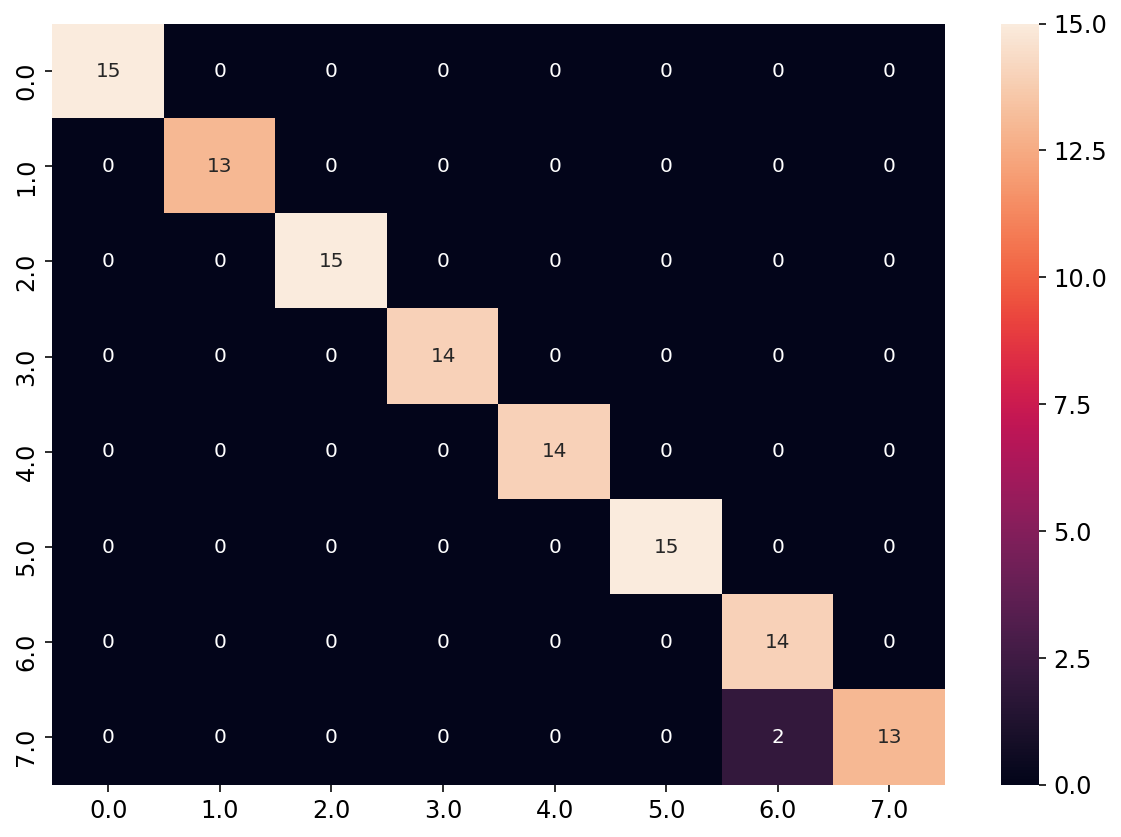

In [38]:
print_cmx(y_test, y_pred)

{'エンタメ': 0,
 'スポーツ': 1,
 'おもしろ': 2,
 '国内': 3,
 '海外': 4,
 'コラム': 5,
 'IT・科学': 6,
 'グルメ': 7}

In [39]:
url_list[-14]

'https://gunosy.com/articles/at5G0'

# Kを変更して検証

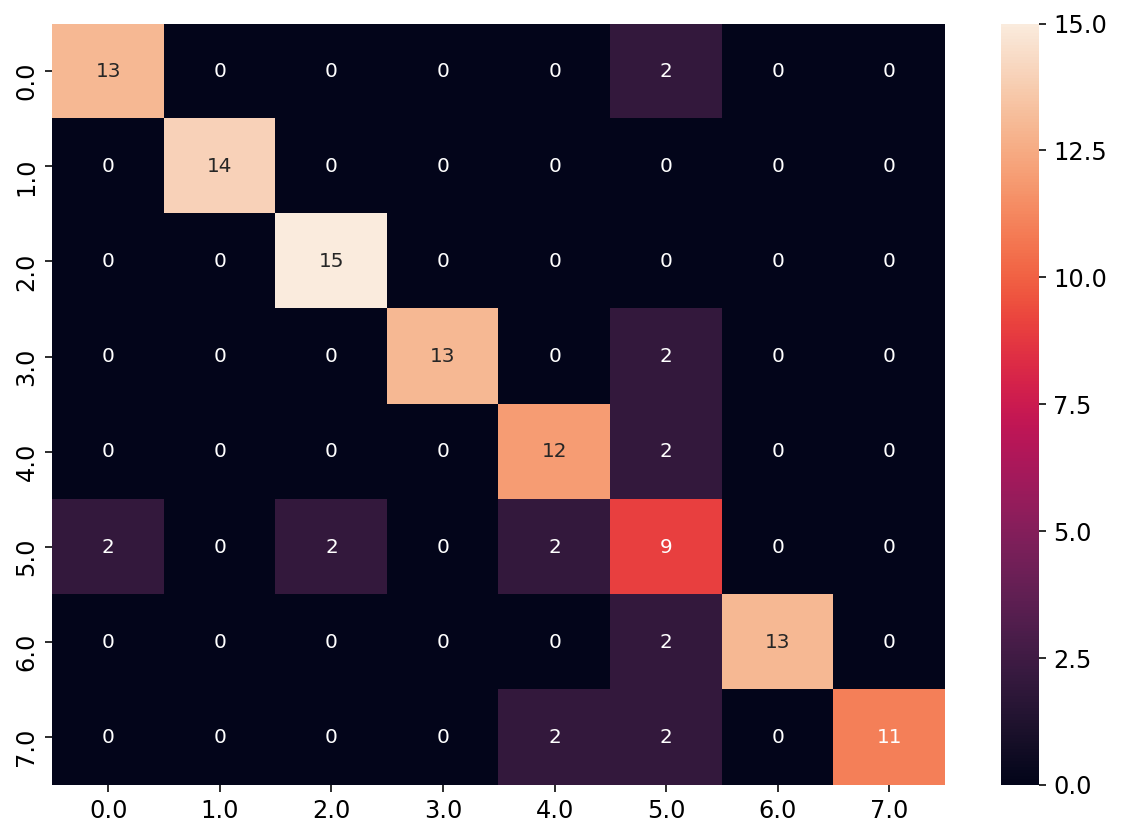

None

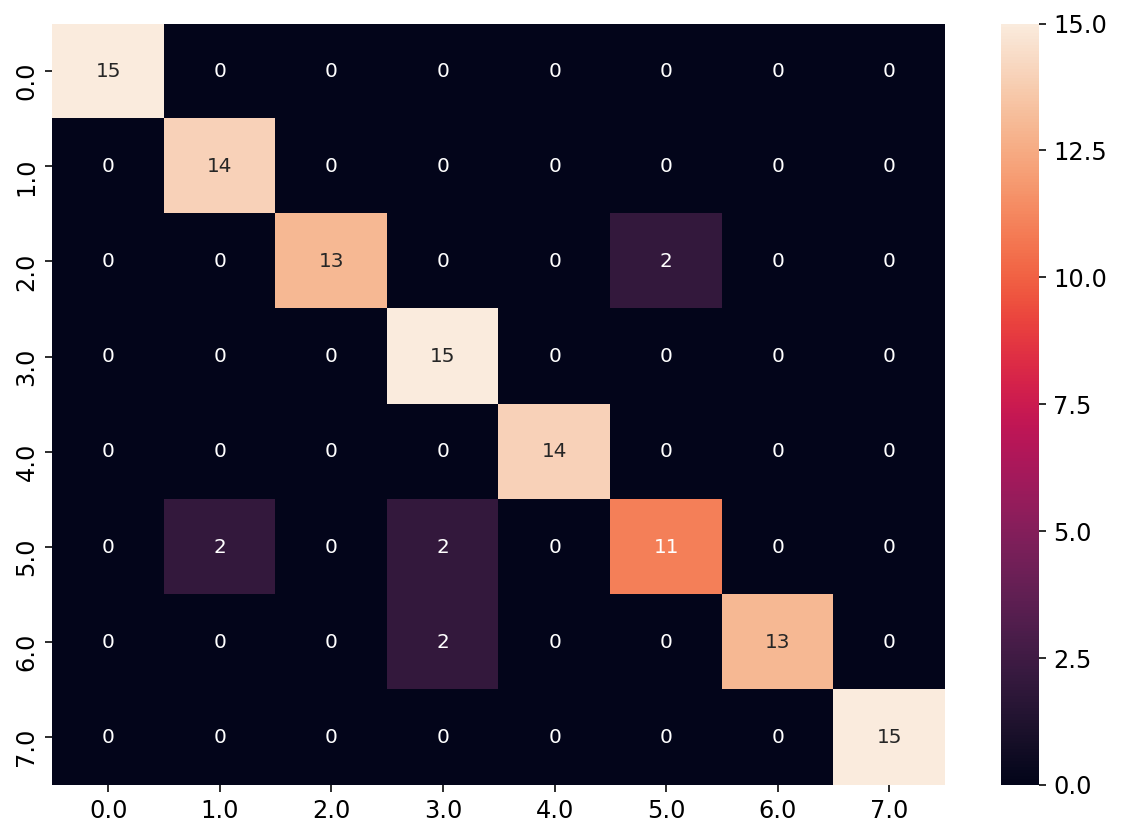

None

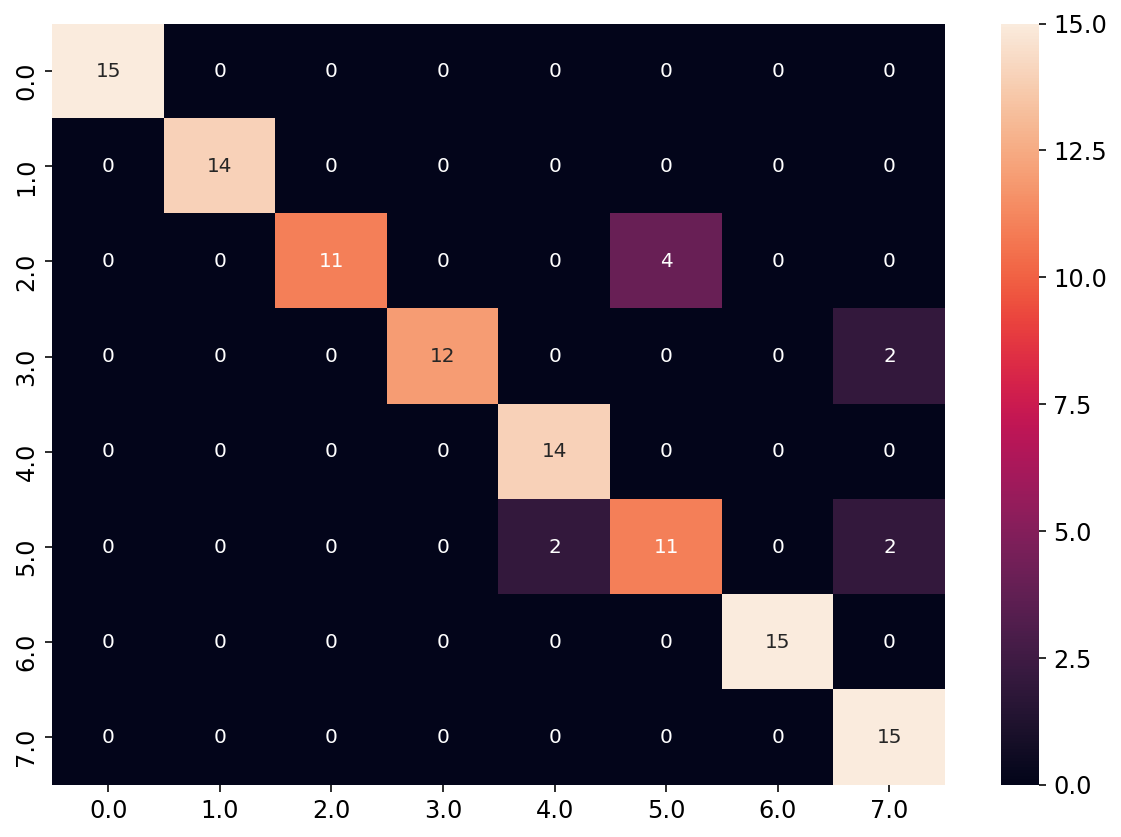

None

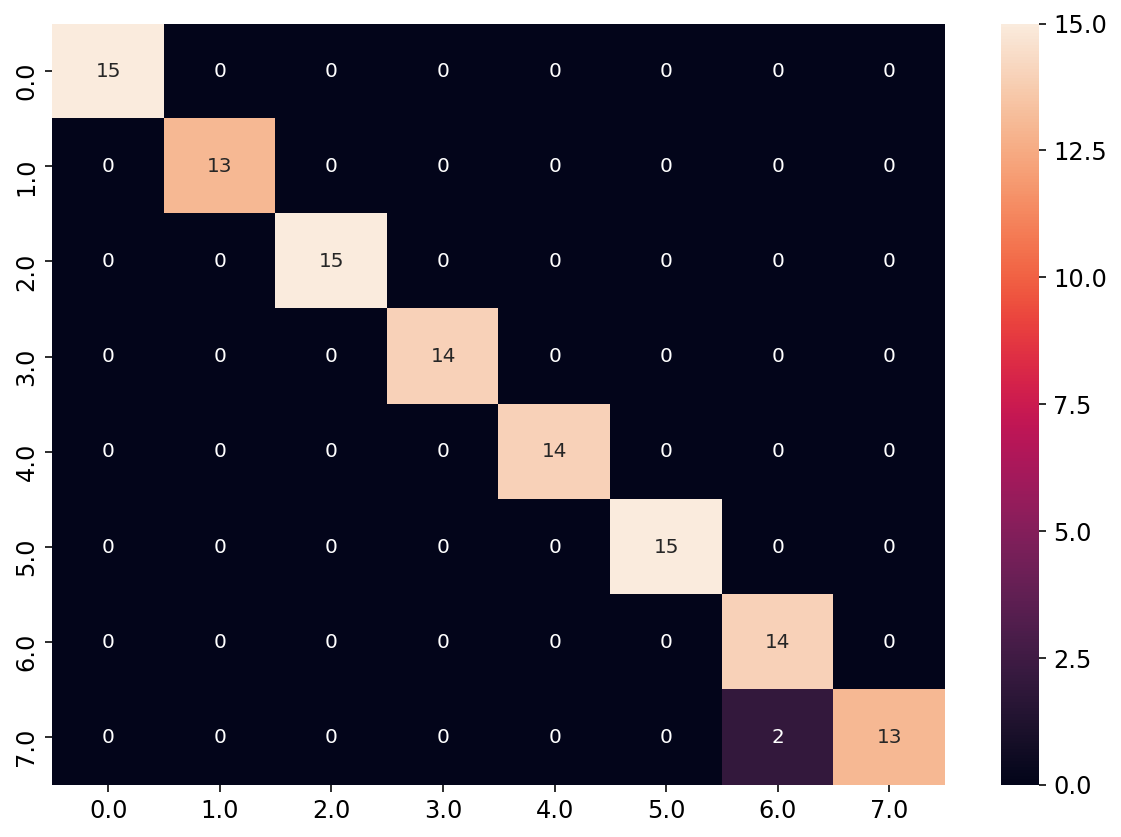

None

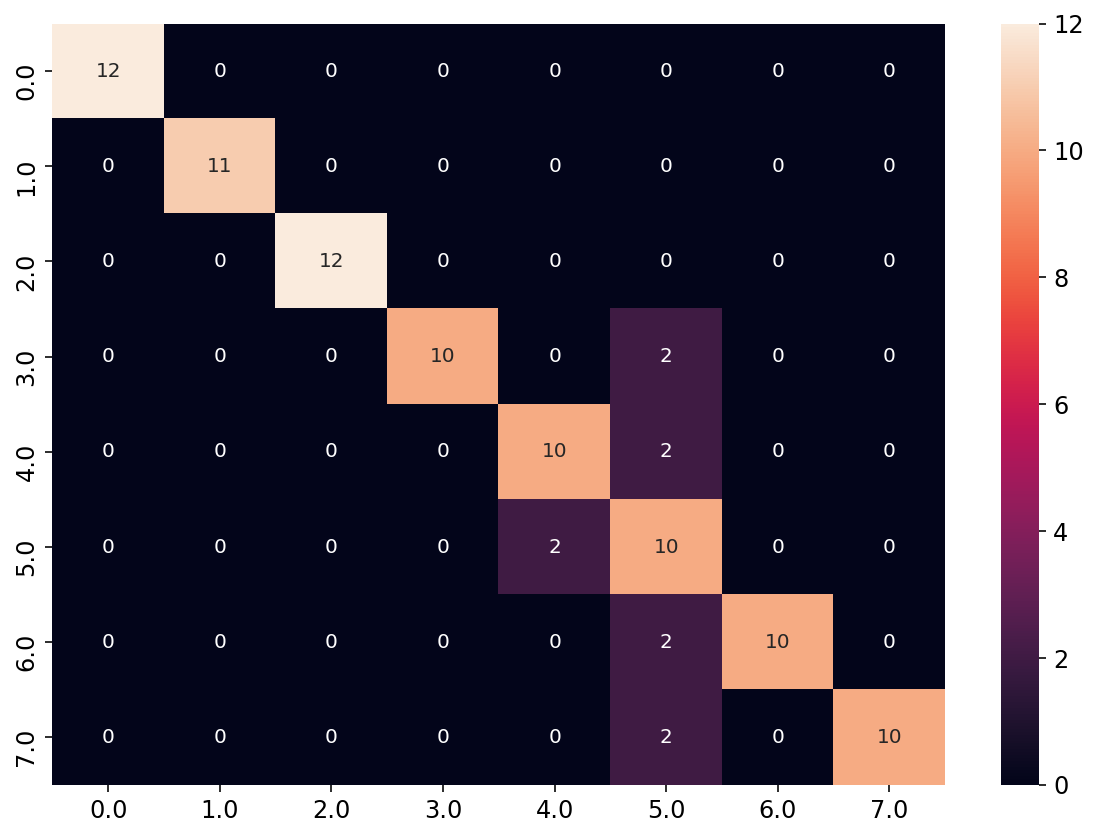

None

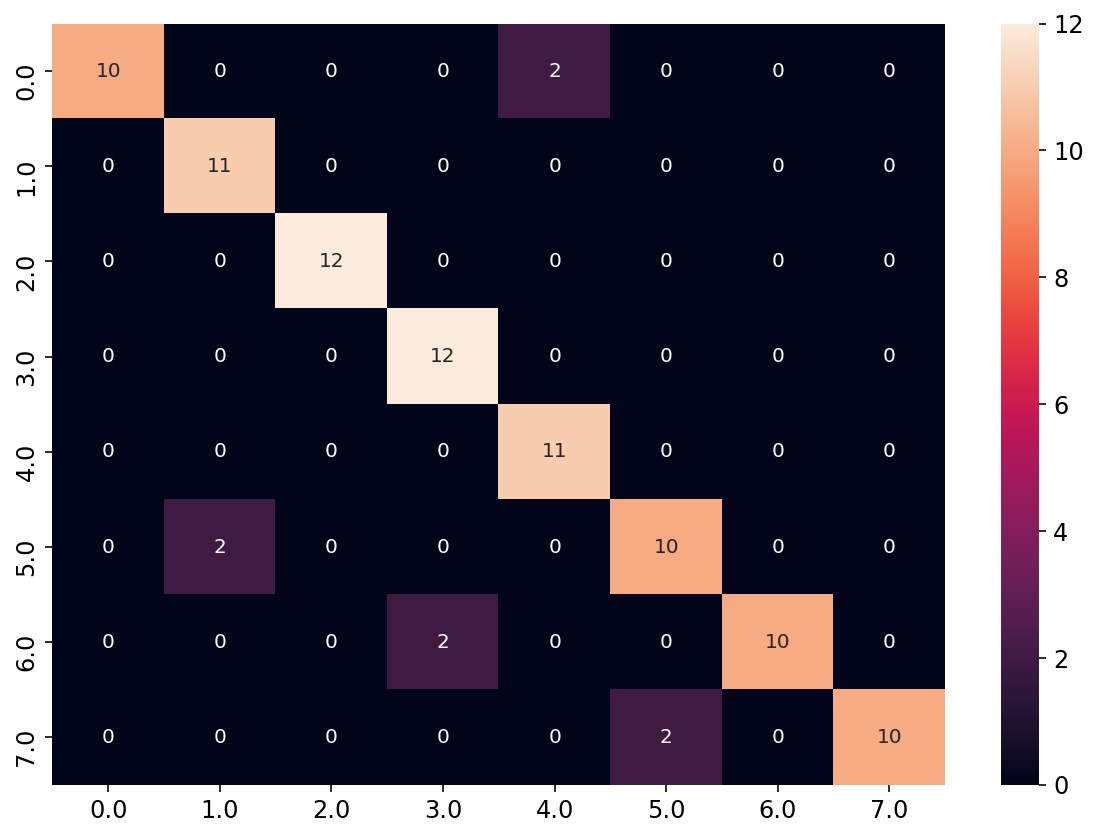

None

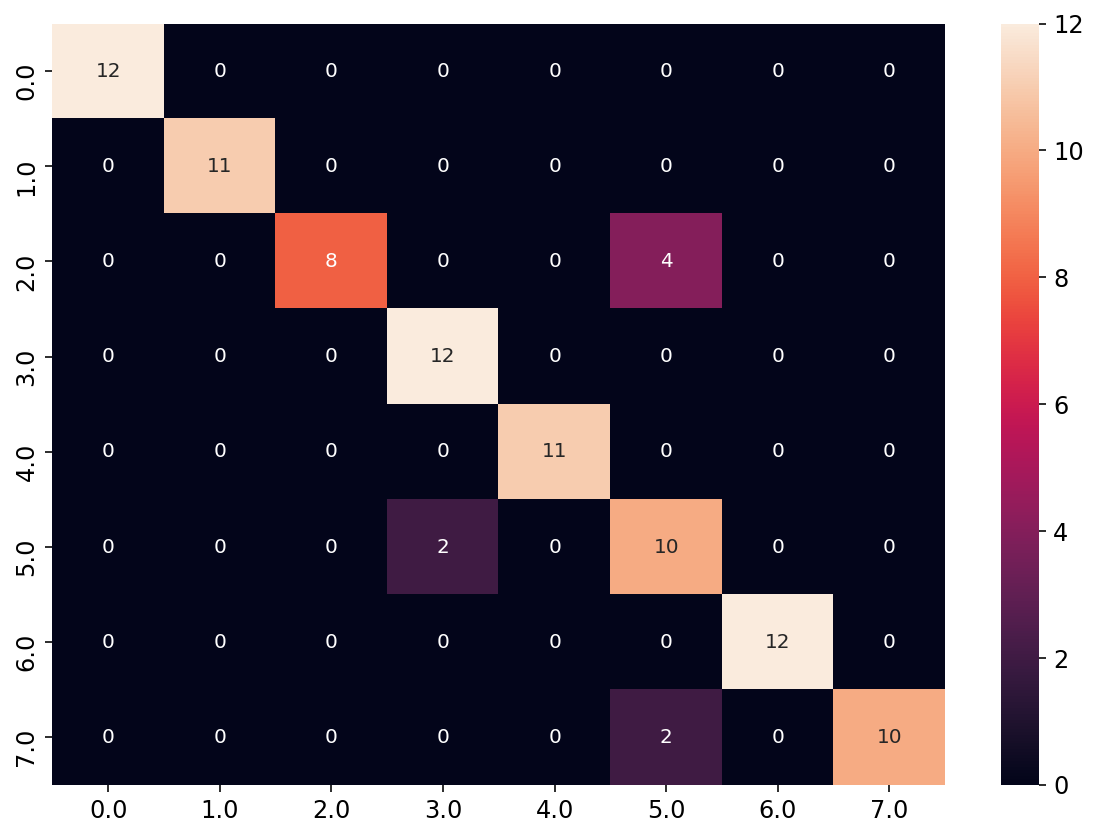

None

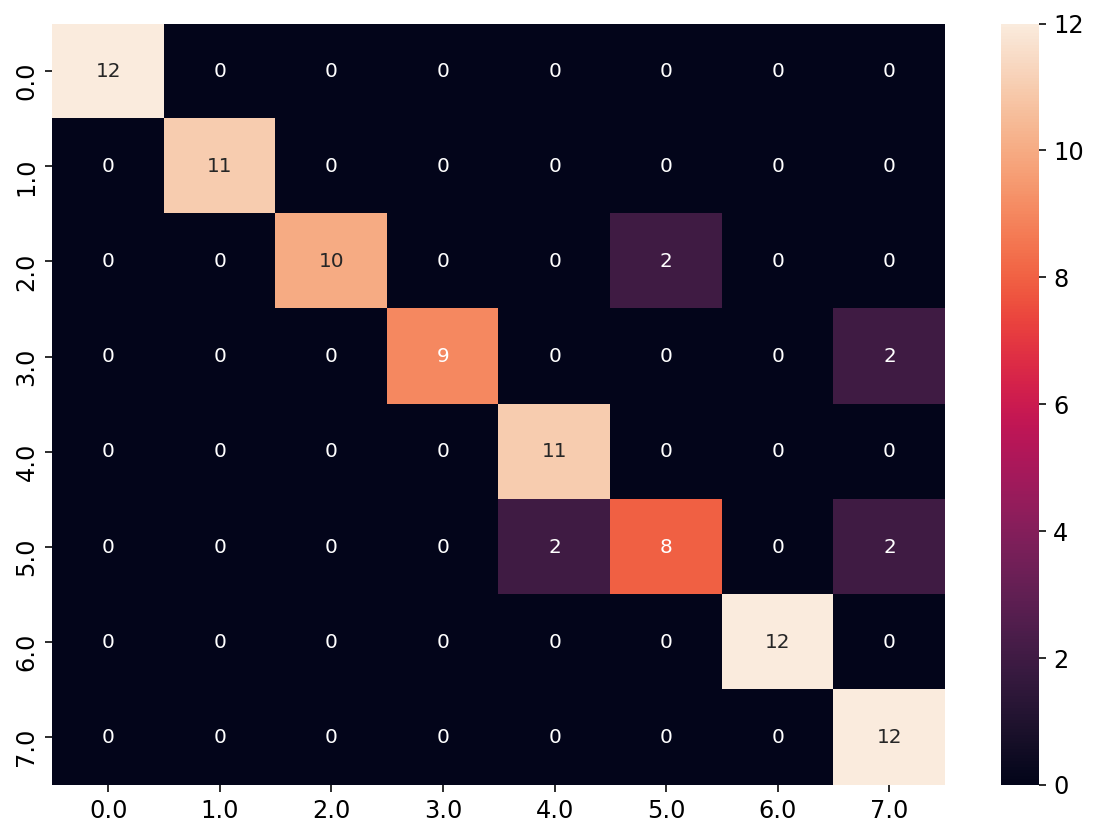

None

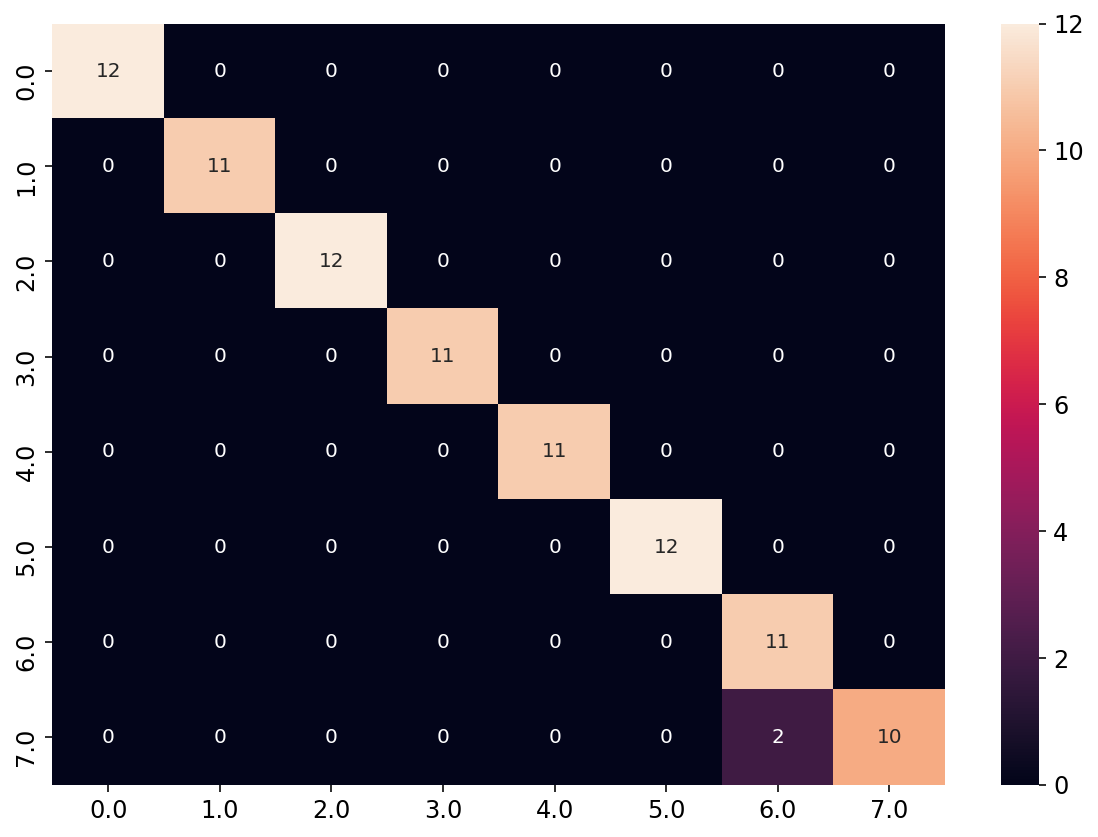

None

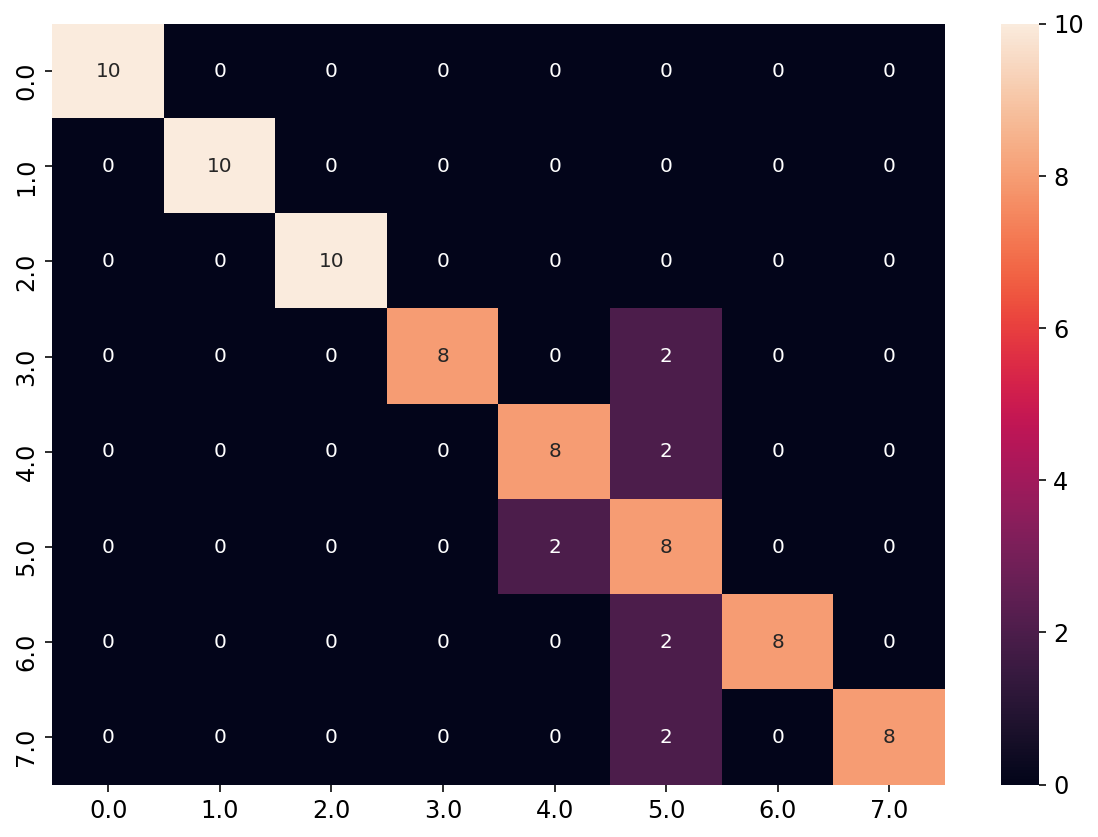

None

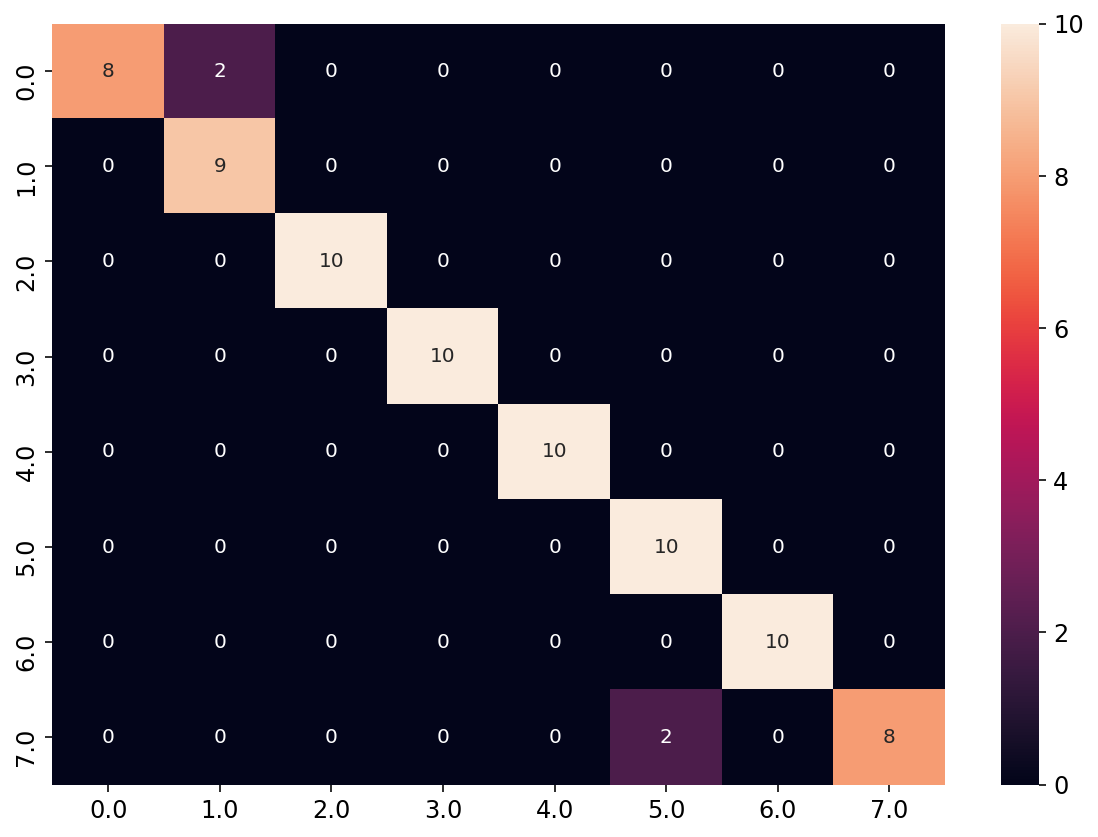

None

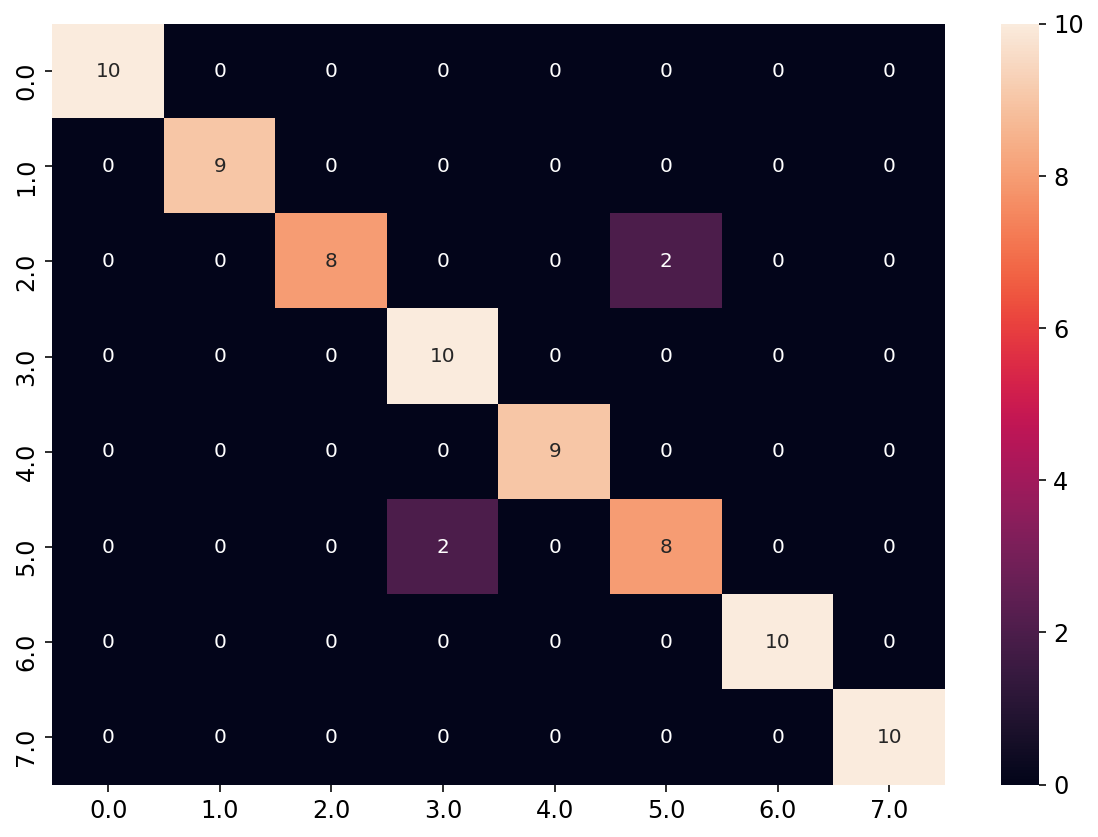

None

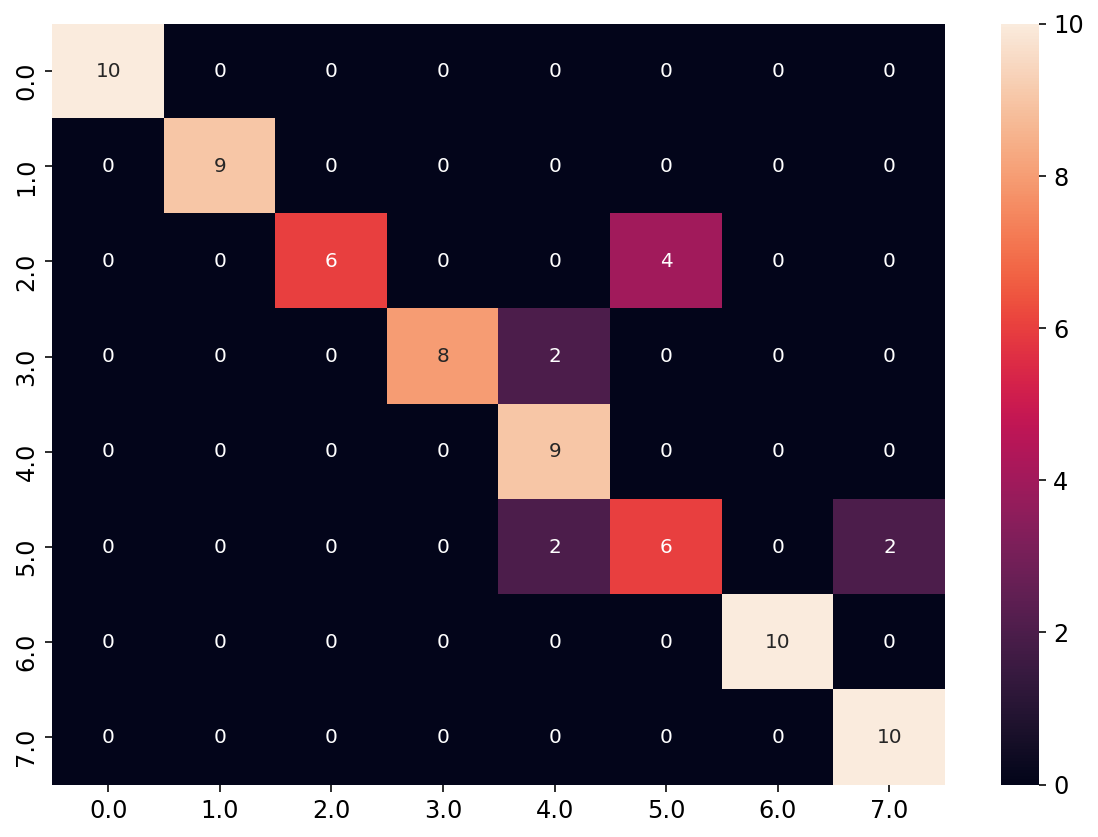

None

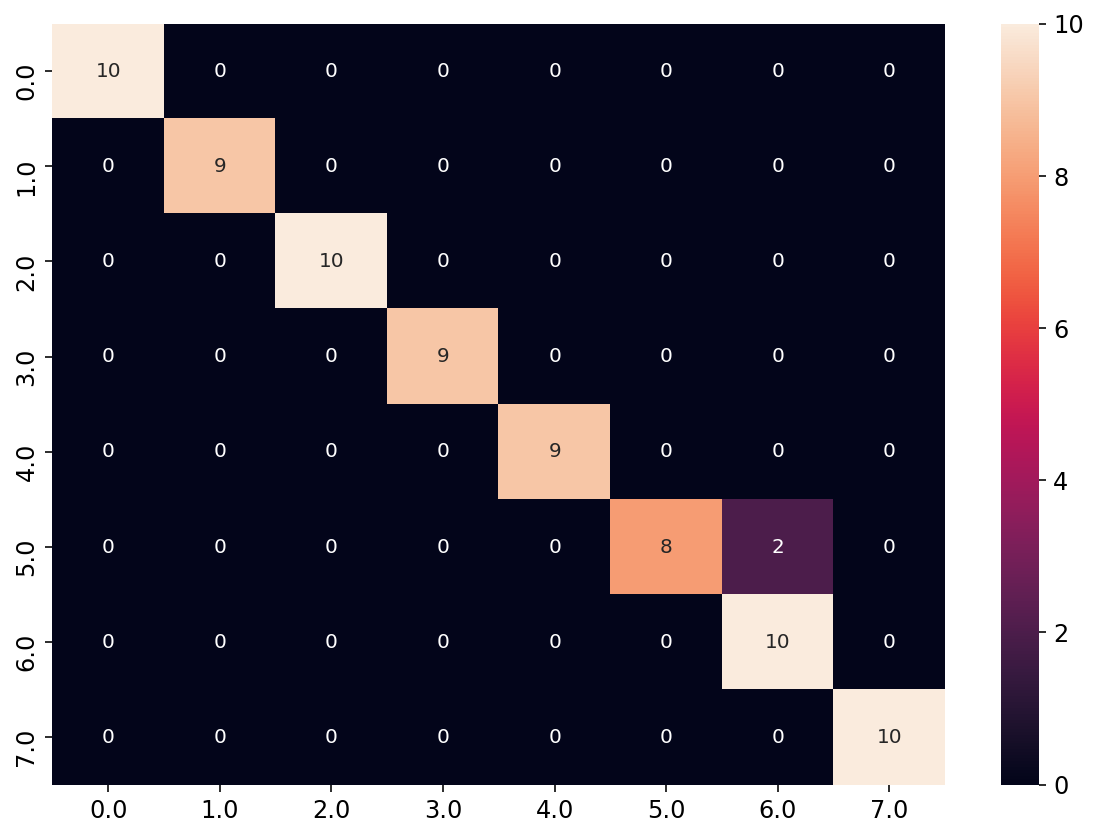

None

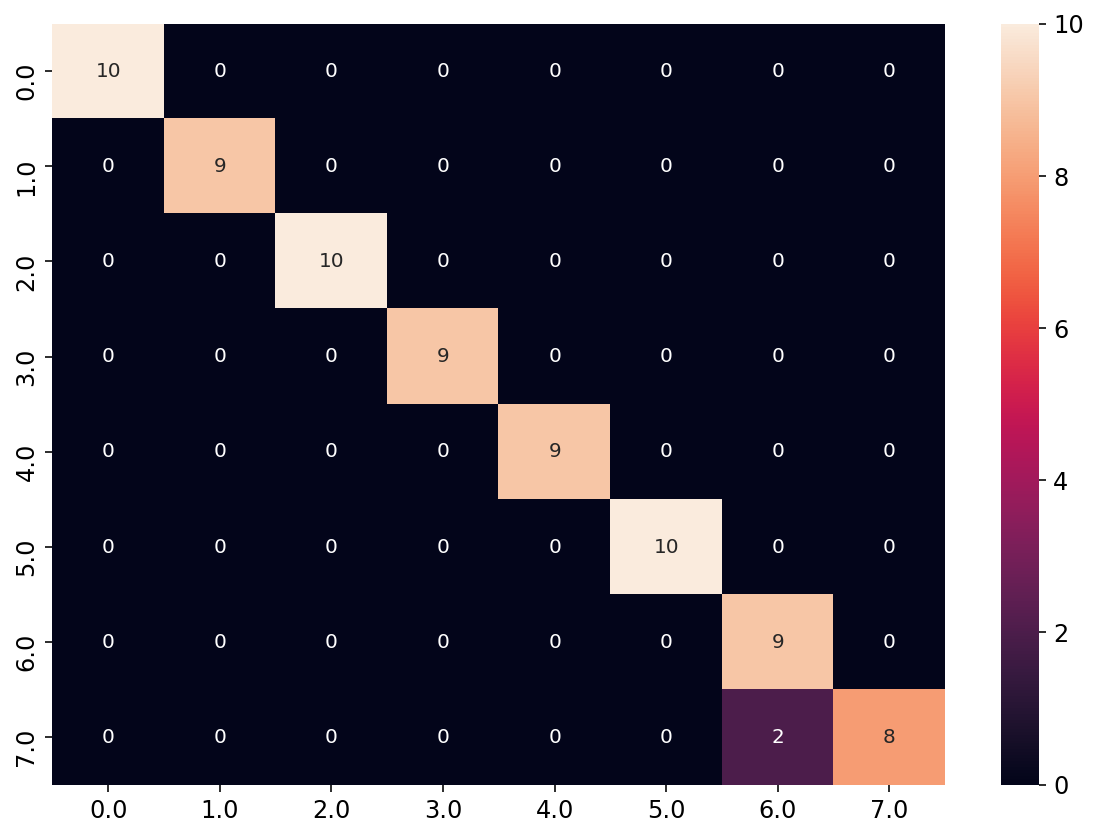

None

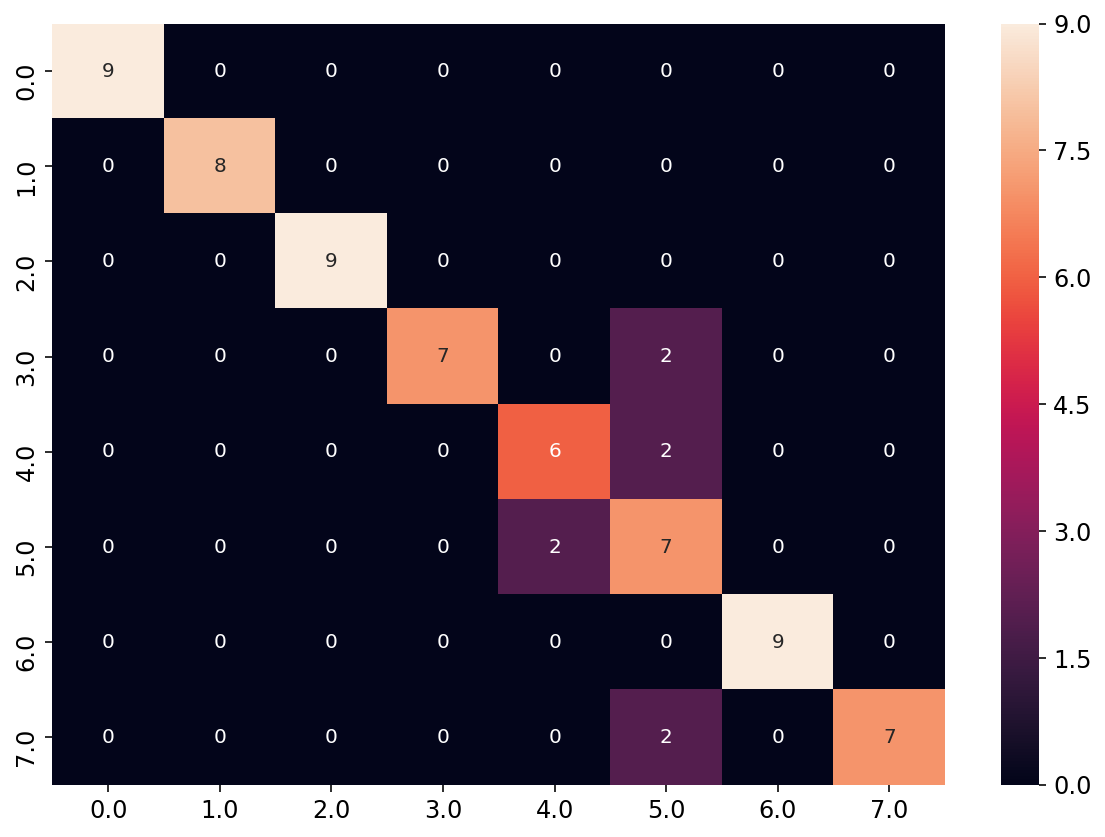

None

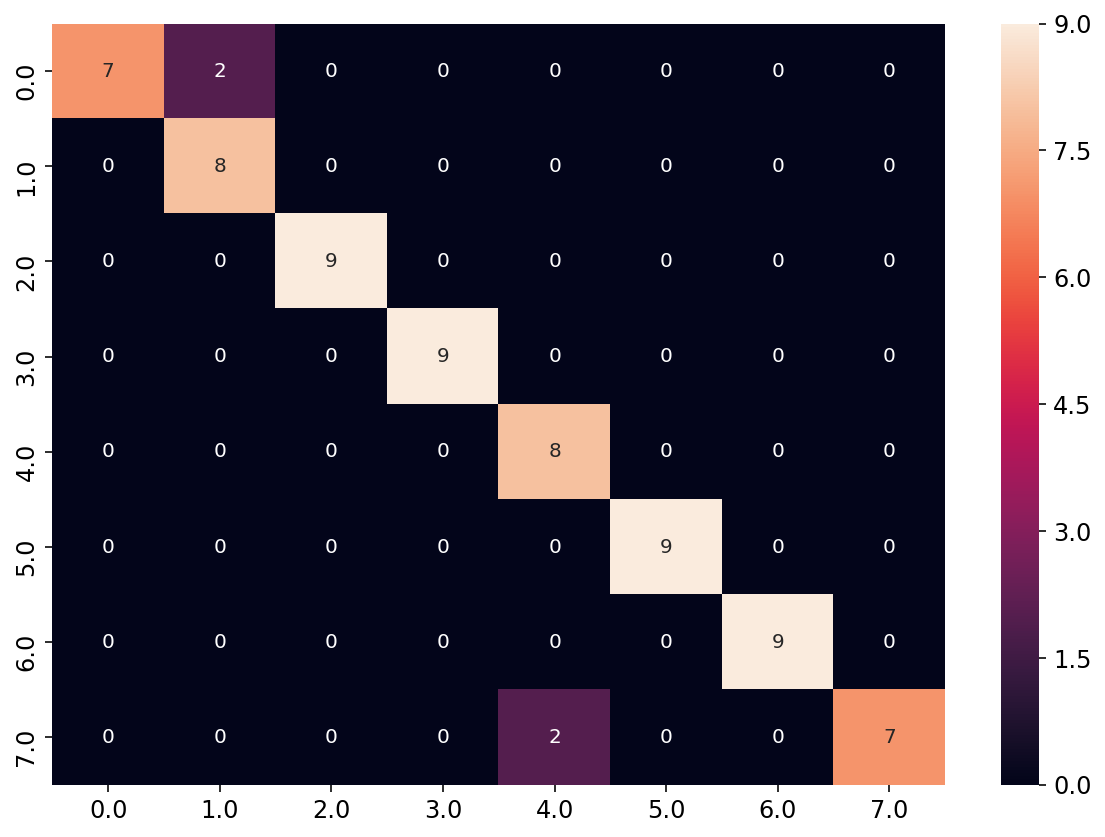

None

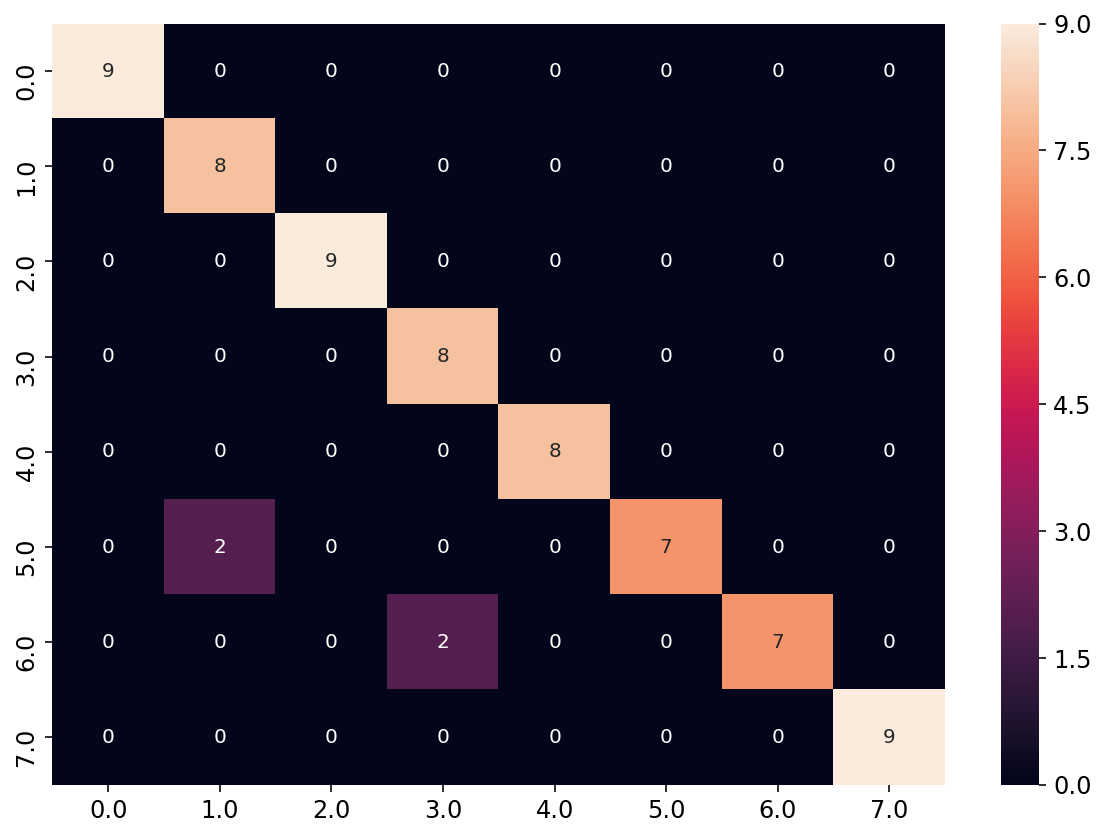

None

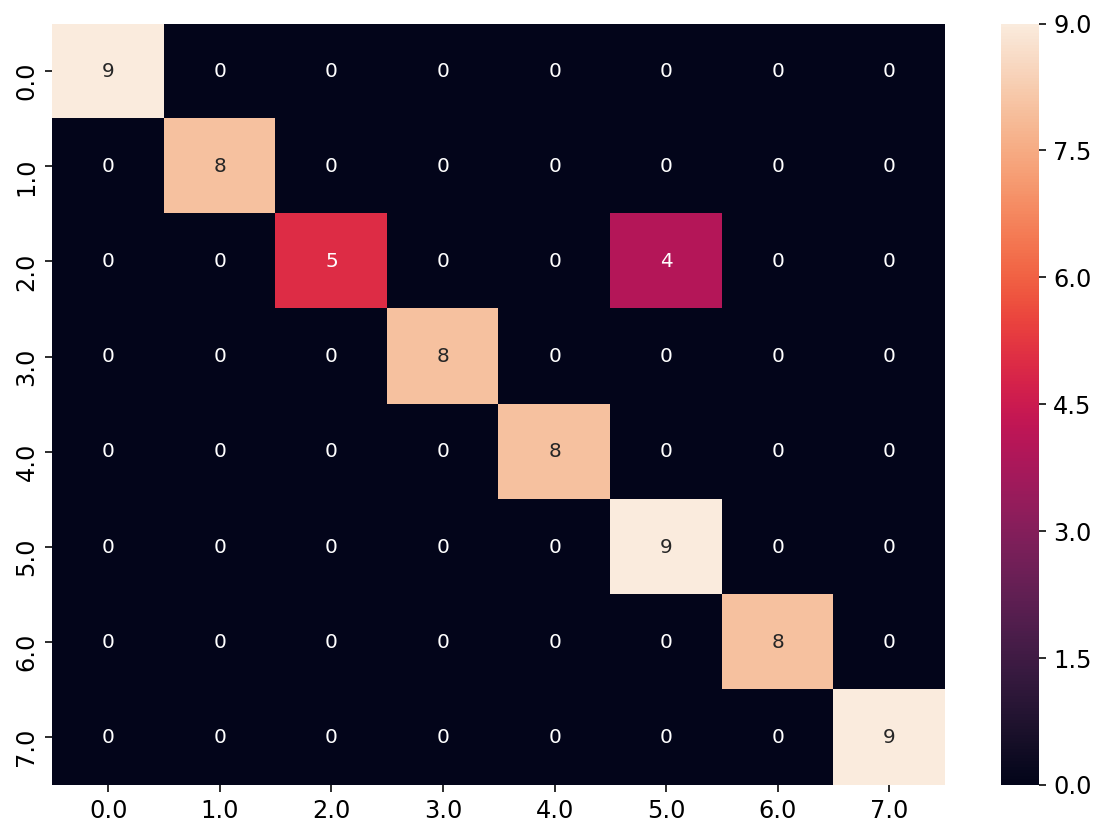

None

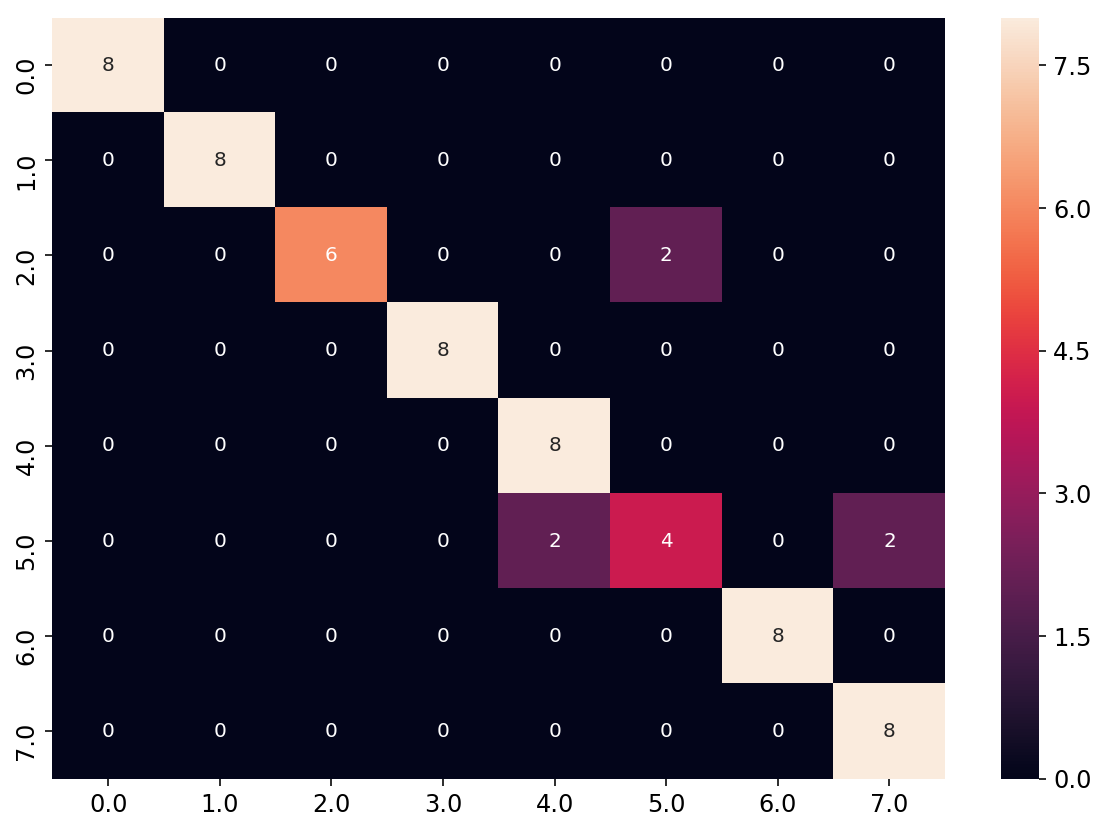

None

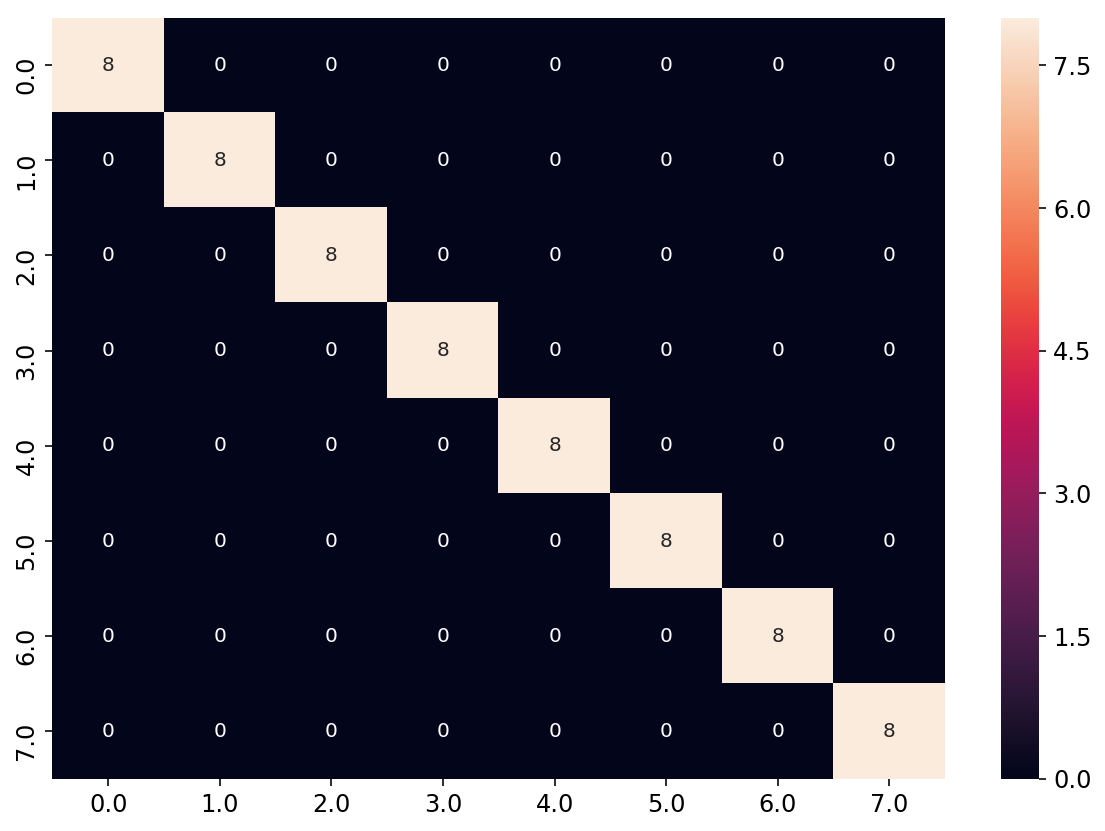

None

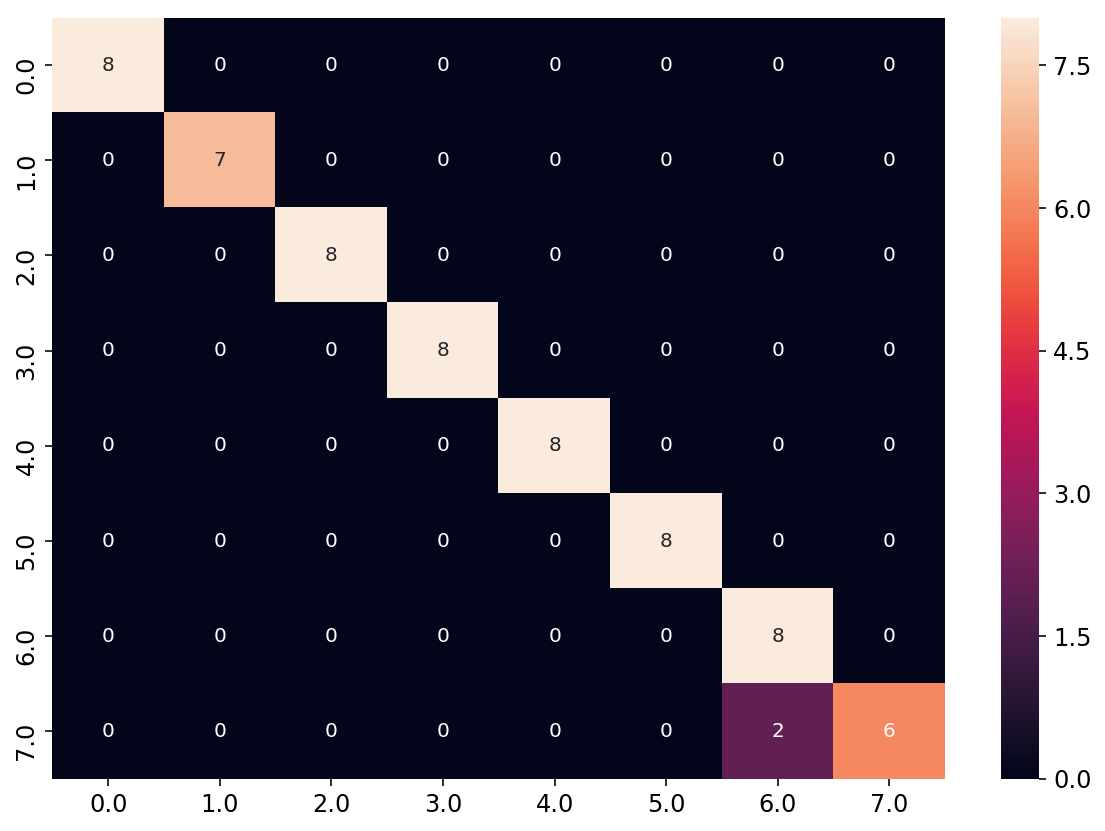

None

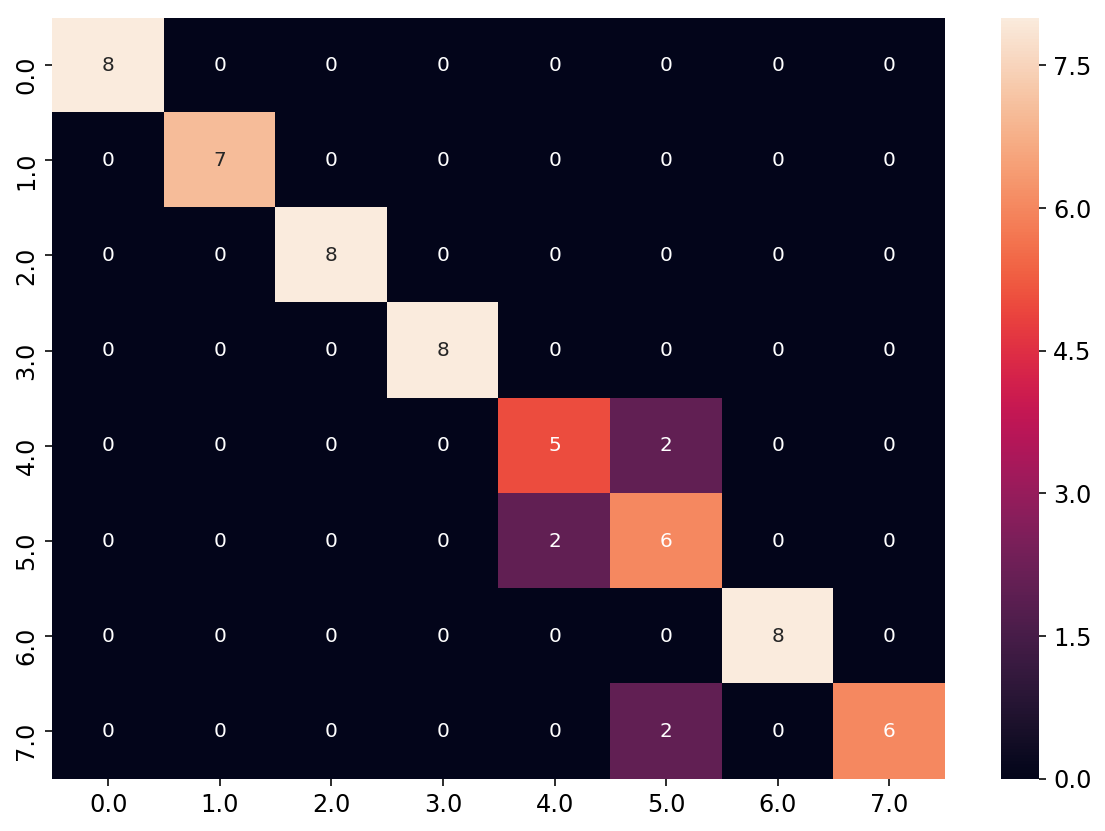

None

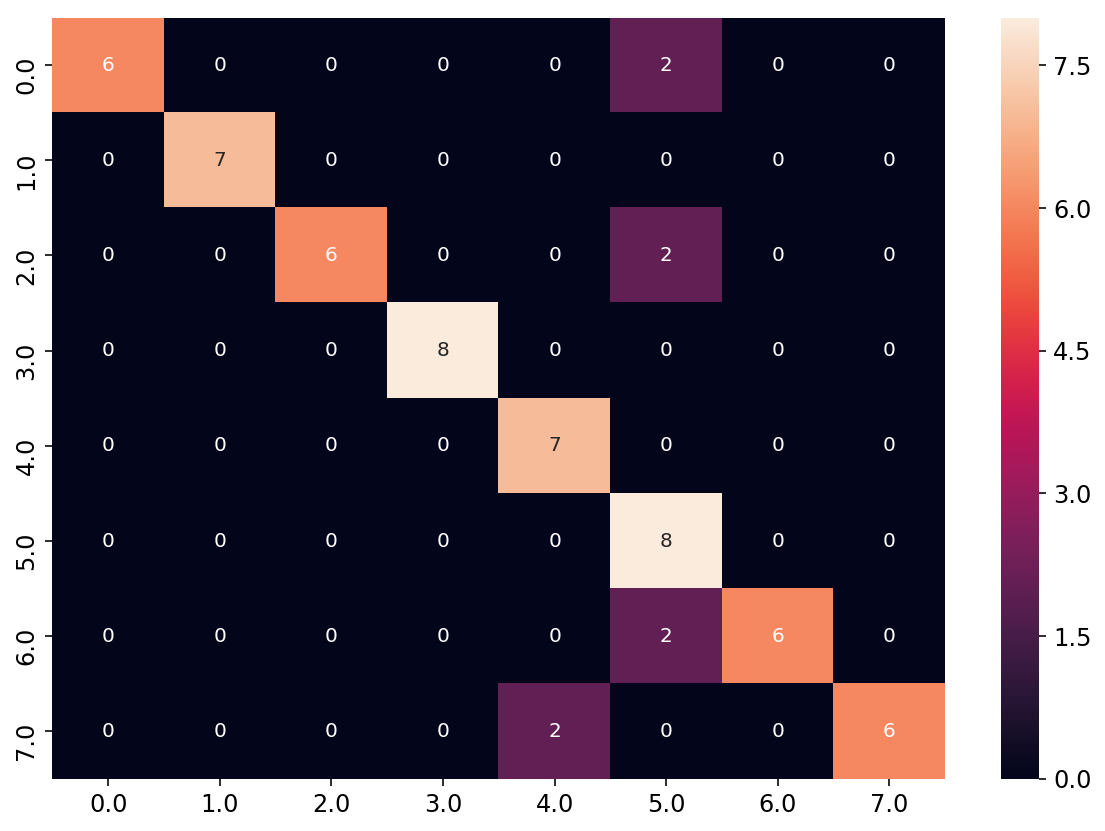

None

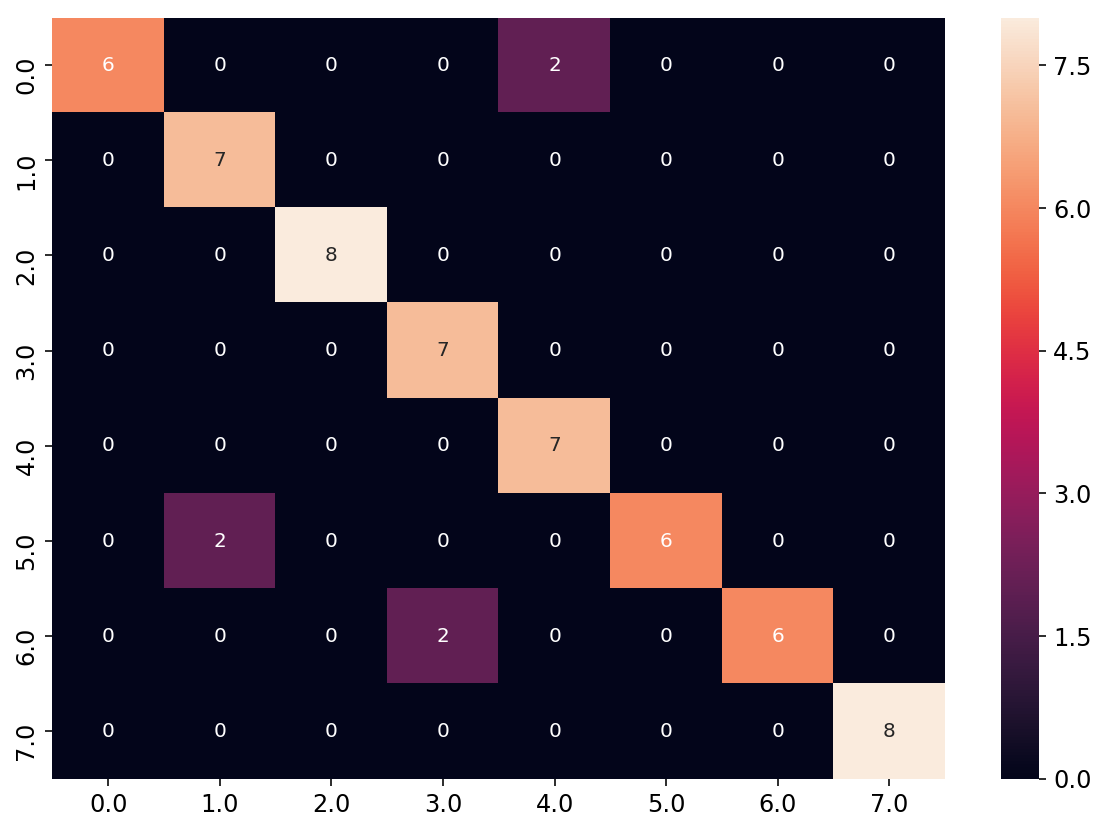

None

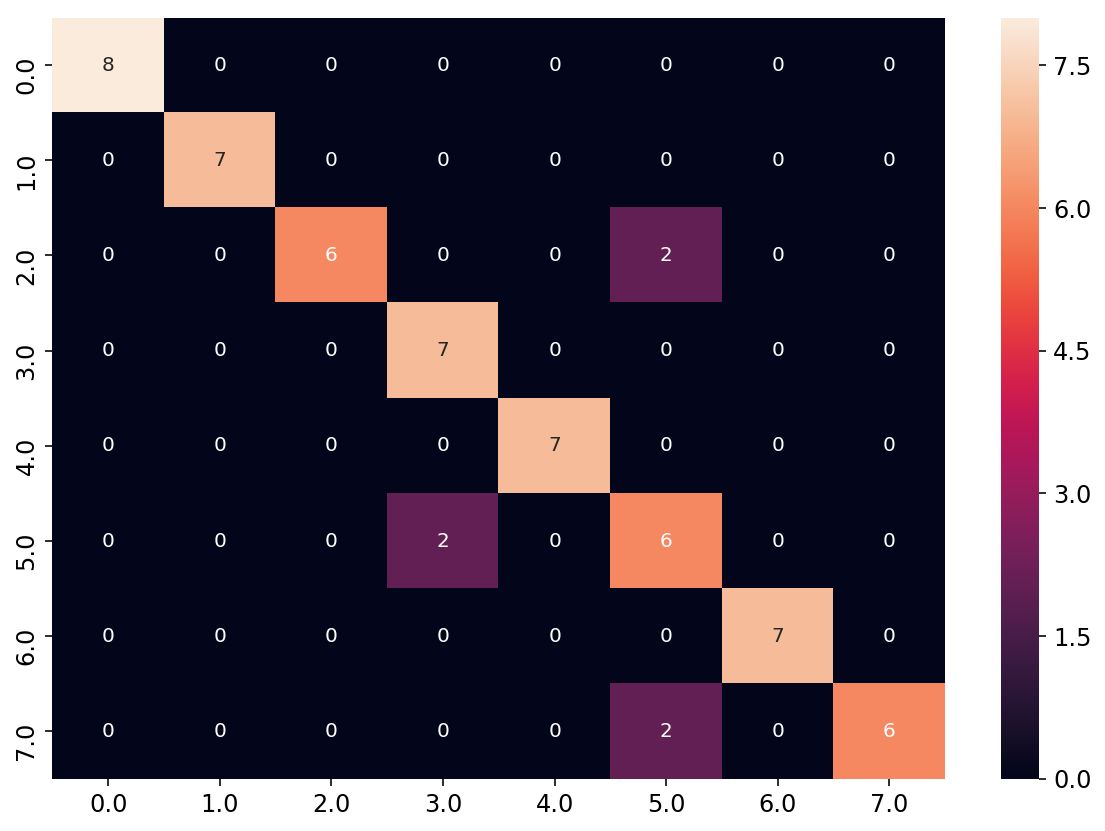

None

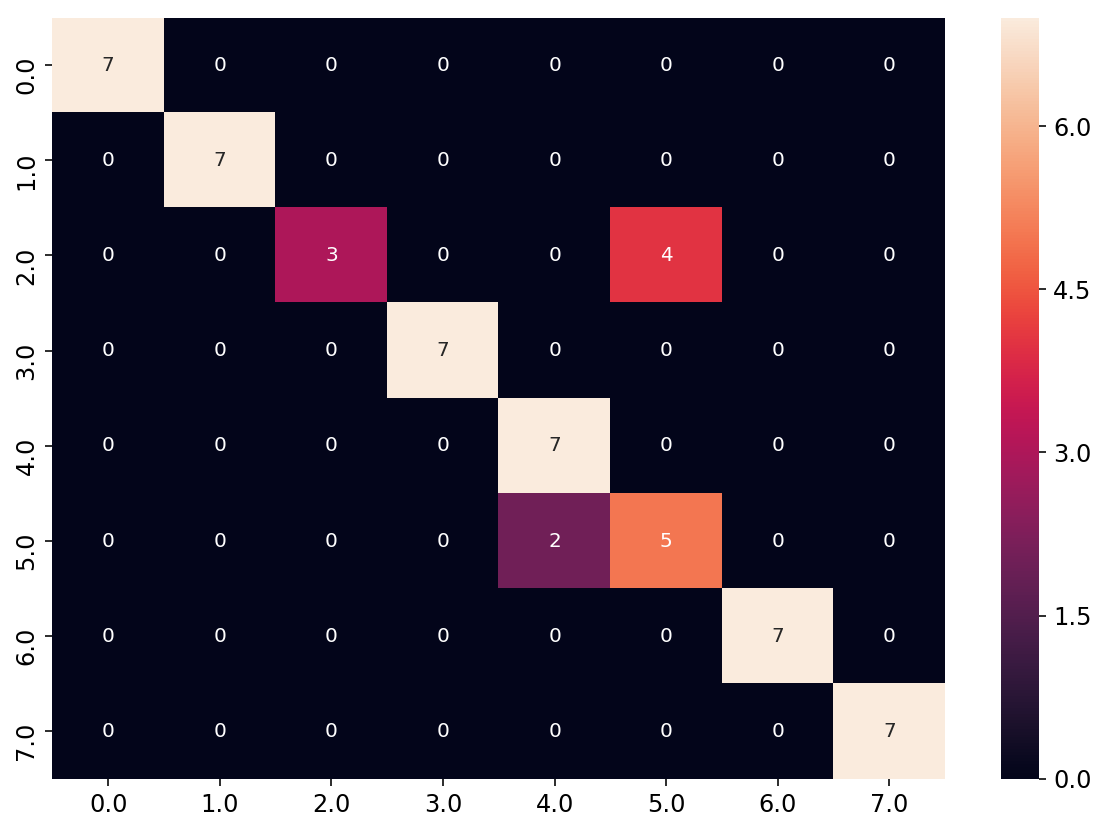

None

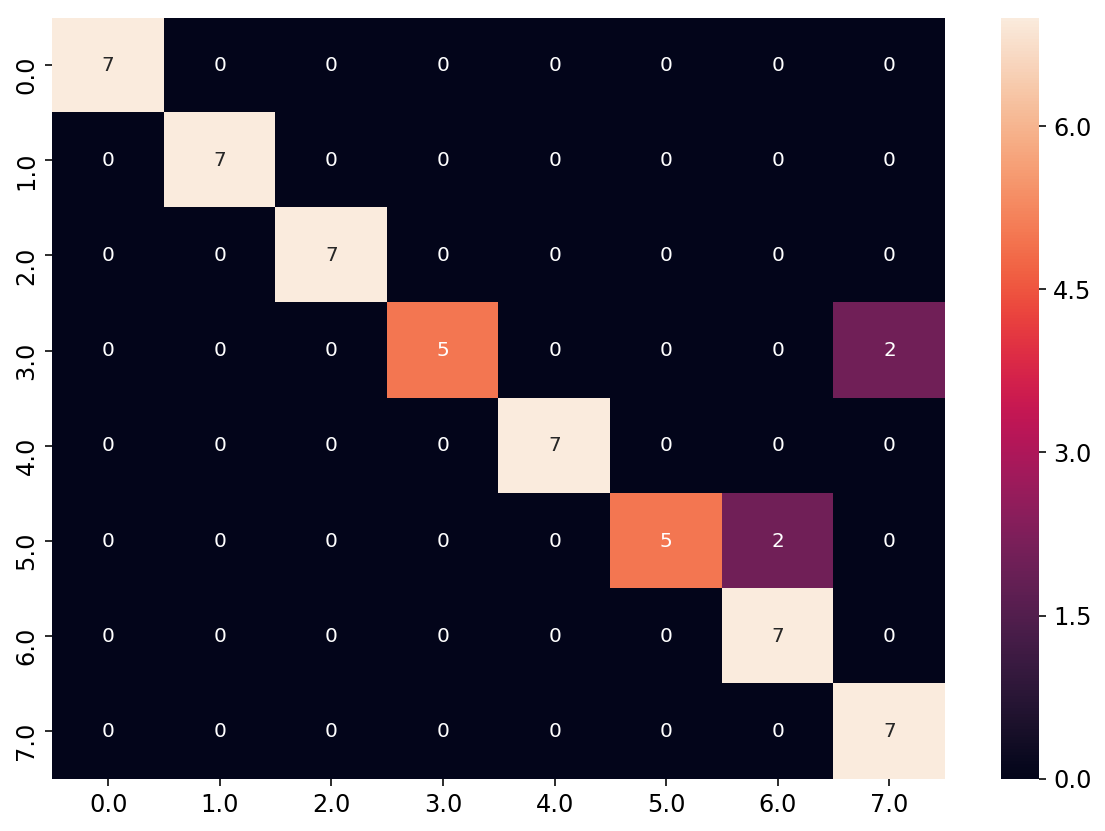

None

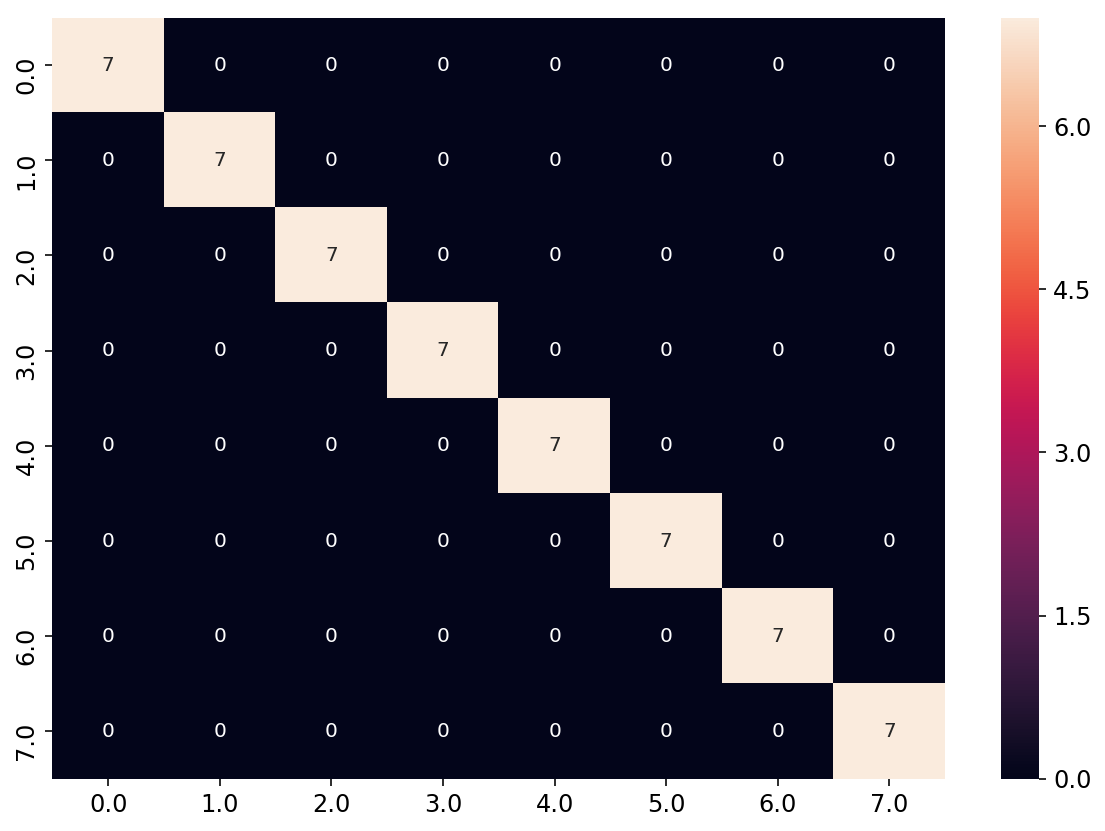

None

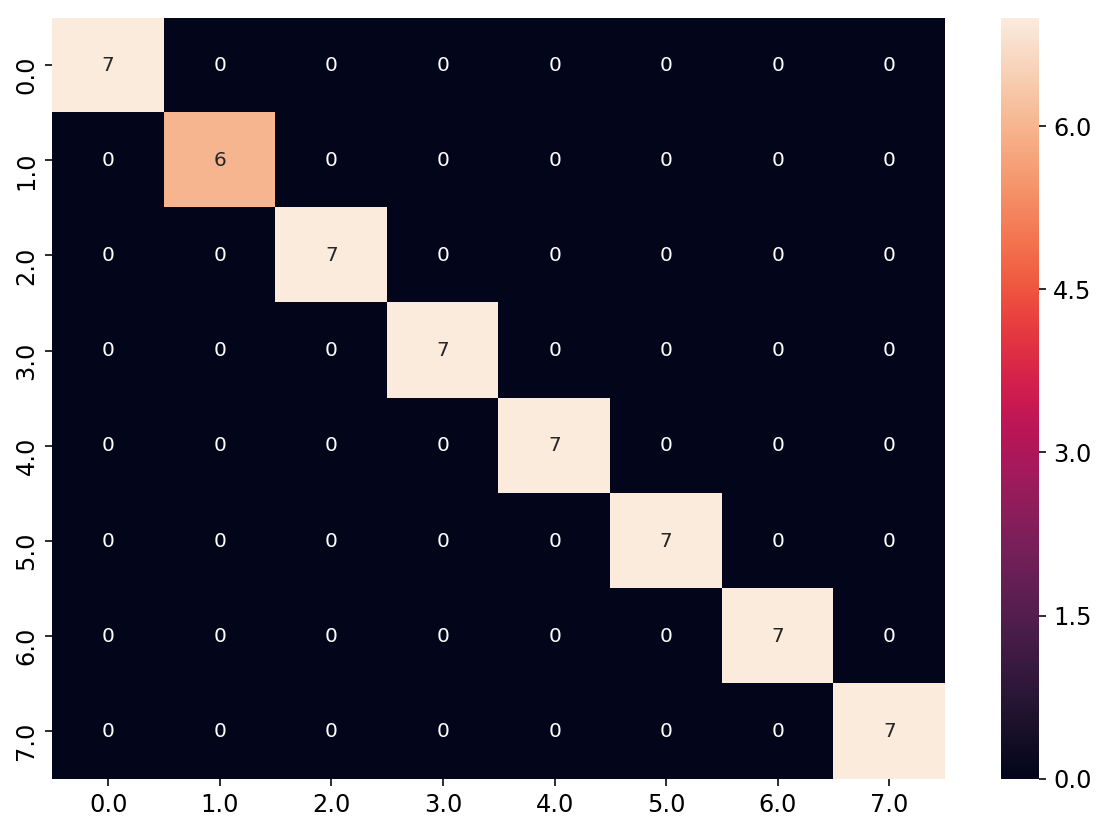

None

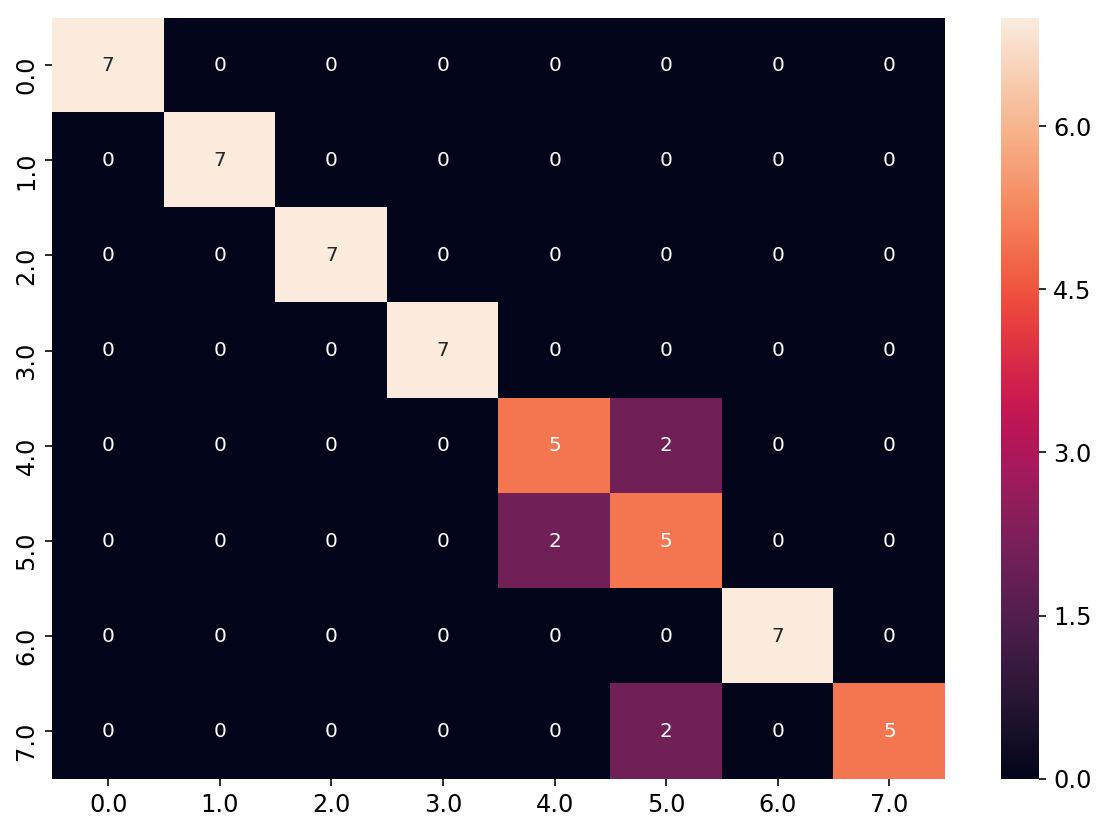

None

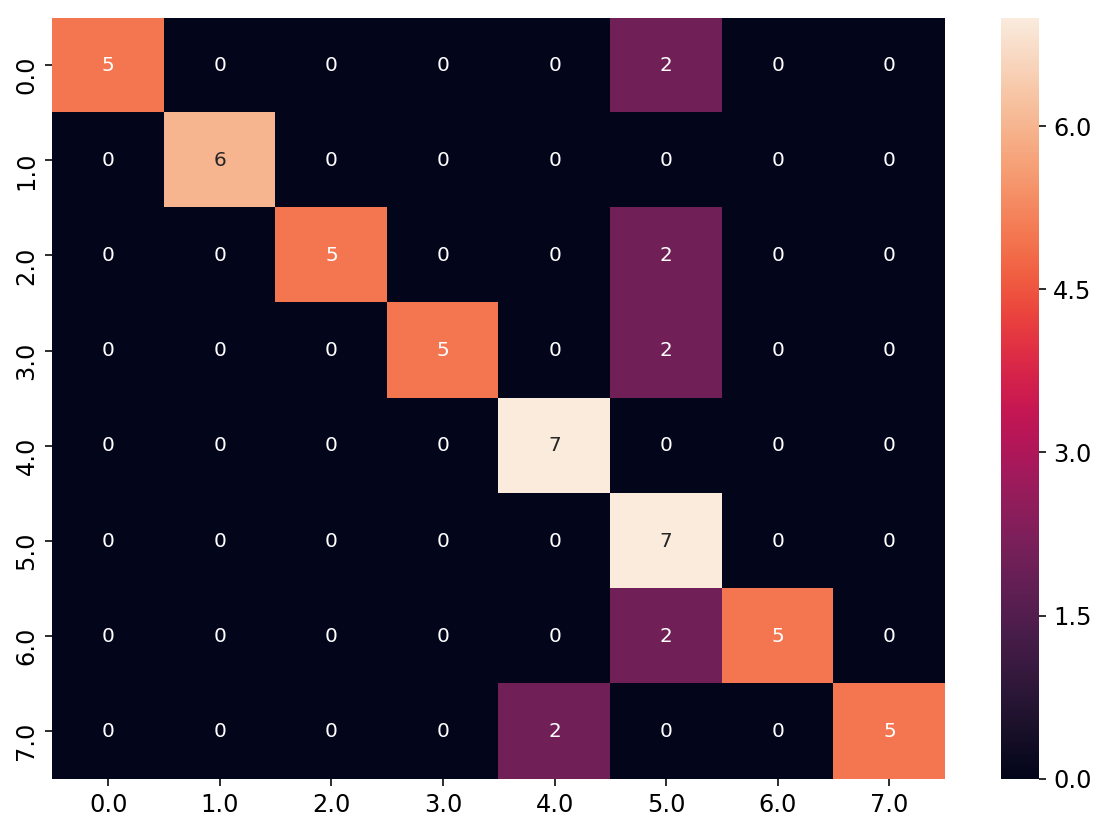

None

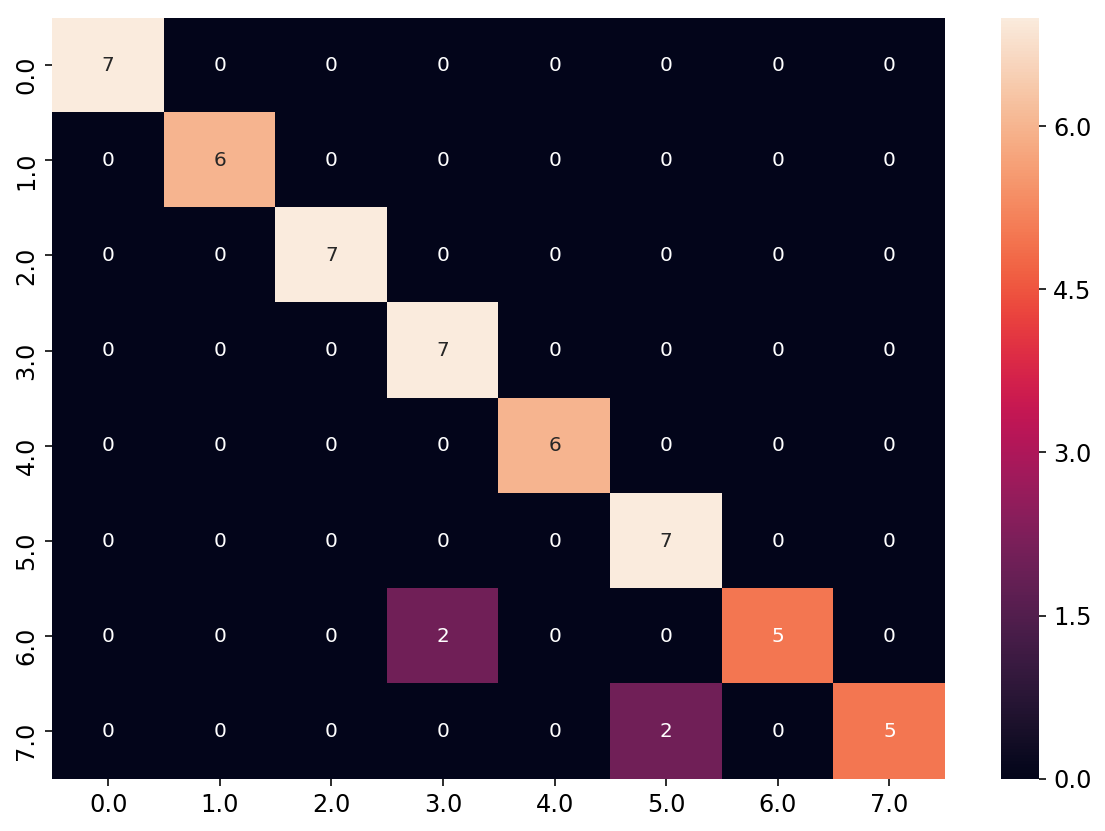

None

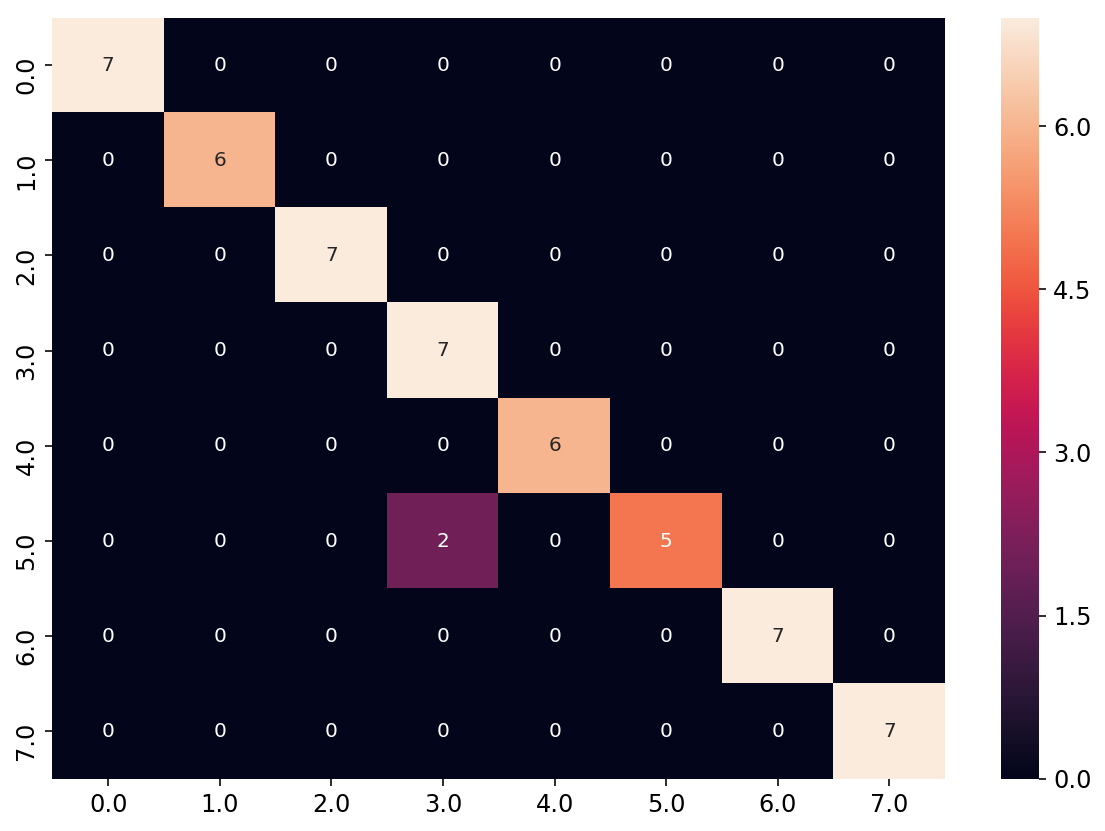

None

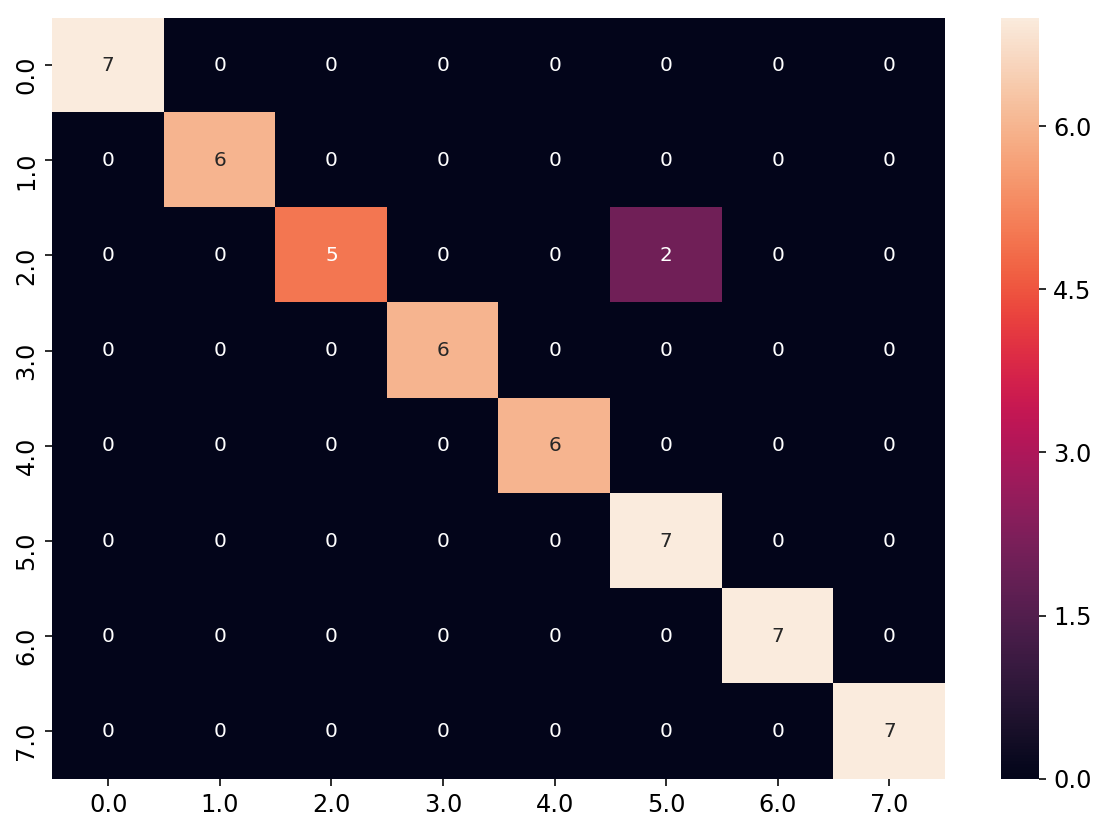

None

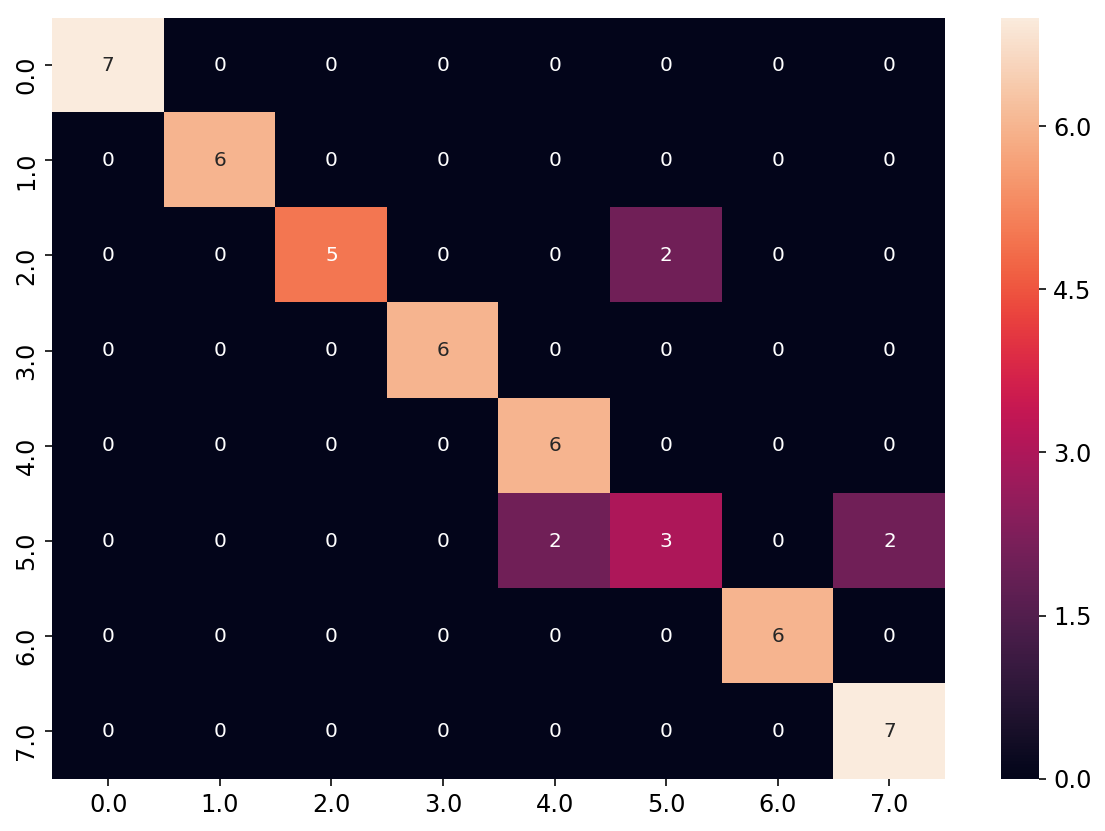

None

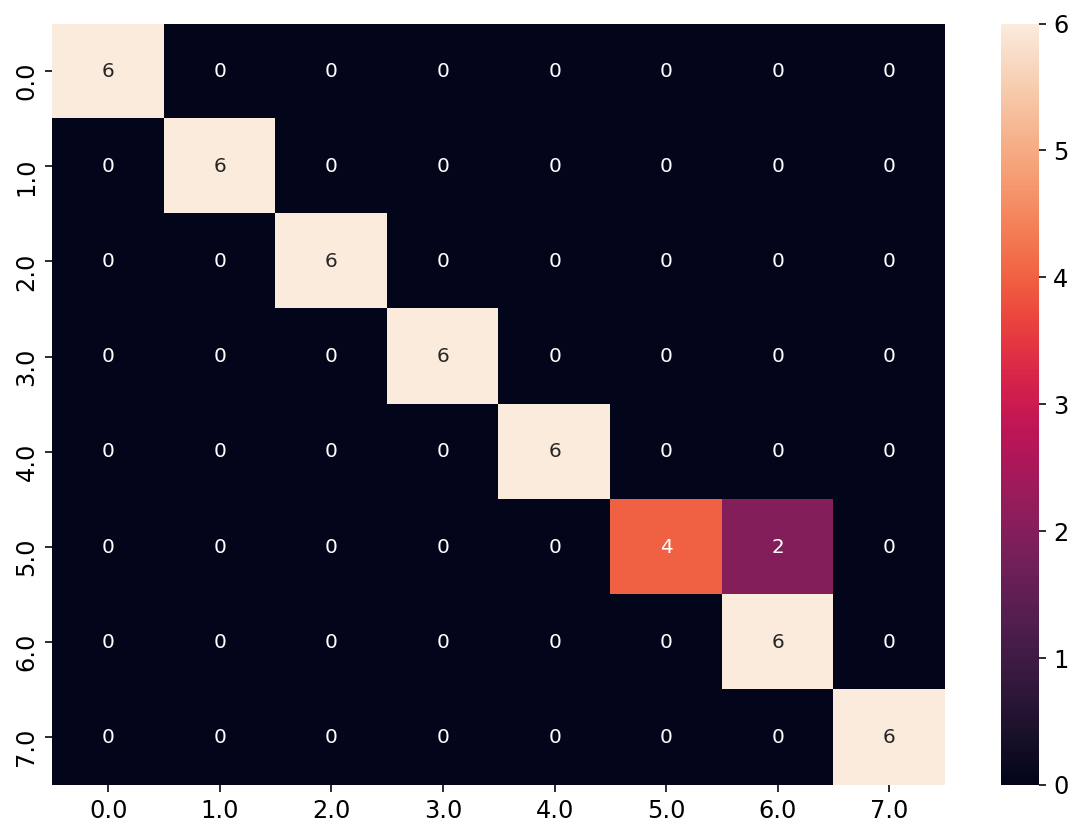

None

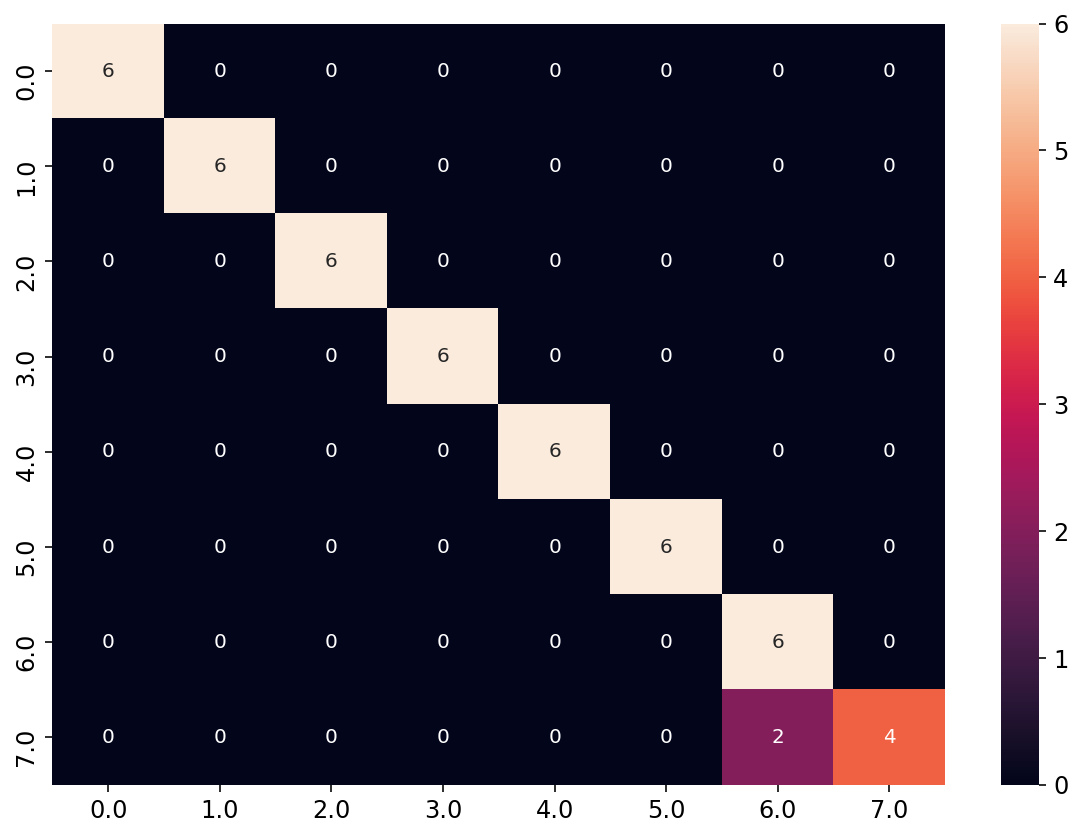

None

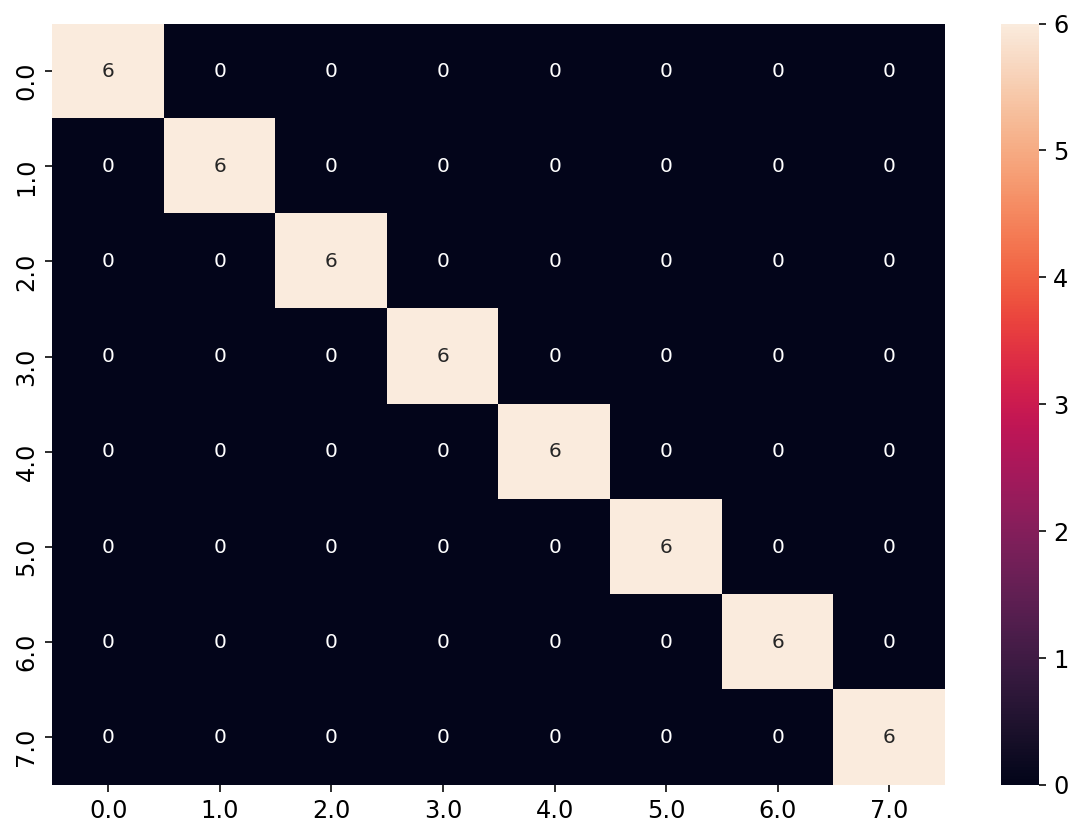

None

In [44]:
score = []

for i in range(4, 10):
    skf = StratifiedKFold(n_splits=i)
    for train_index, test_index in skf.split(X,y):
        y_test = y[test_index]
        X_train = X.iloc[train_index]
        y_train = y[train_index]
        X_test = X.iloc[test_index]
        
        model = GaussianNB()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        display(print_cmx(y_test, y_pred))
        score.append(model.score(X_test, y_test))

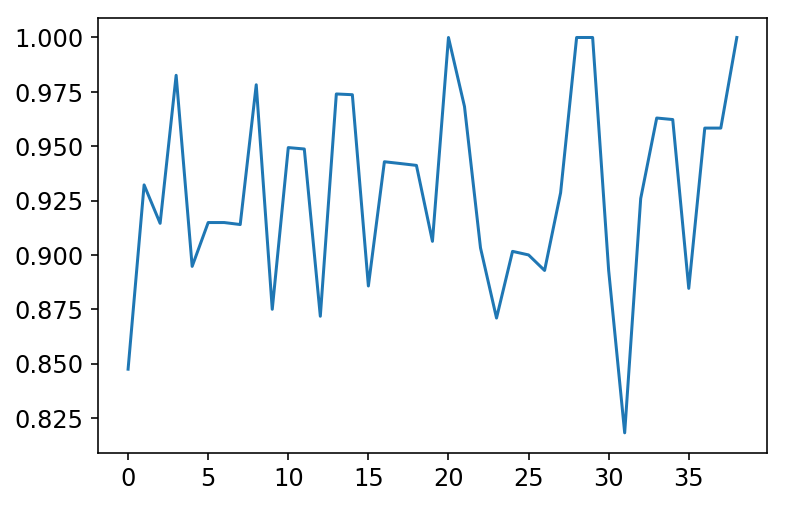

In [45]:
plt.plot(score)

In [46]:
np.mean(score)

0.9290556289818662